In [ ]:
import requests
import pandas as pd
import csv
import json
from datetime import datetime
import time
import os
from google.colab import userdata

# GitHub API configuration
GITHUB_API_URL = "https://api.github.com"
GITHUB_TOKEN = userdata.get("GITHUB_TOKEN")

headers = {
    "Authorization": f"token {GITHUB_TOKEN}",
    "Accept": "application/vnd.github.v3+json"
}

#Data Acquisition

Priority labels got from: https://arxiv.org/pdf/2405.10891

In [ ]:
def check_rate_limit():
    response = requests.get(f"{GITHUB_API_URL}/rate_limit", headers=headers)
    if response.status_code == 200:
        data = response.json()
        remaining = data['resources']['core']['remaining']
        reset_time = data['resources']['core']['reset']
        if remaining < 10:
            wait_time = reset_time - int(time.time()) + 1
            print(f"Rate limit almost exceeded. Waiting for {wait_time} seconds.")
            time.sleep(wait_time)
    else:
        print(f"Error checking rate limit: {response.status_code}")
        time.sleep(60)  # Wait for a minute if we can't check the rate limit

def make_request(url, params=None):
    check_rate_limit()
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    elif response.status_code == 403 and 'rate limit exceeded' in response.text.lower():
        print("Rate limit exceeded. Waiting for reset...")
        time.sleep(3600)  # Wait for an hour
        return make_request(url, params)  # Retry the request
    else:
        print(f"Error making request to {url}: {response.status_code}")
        print(response.text)
        return None

def get_repo_iterator(count=5000, start_page=1, initial_max_stars=None):
    page = start_page
    per_page = 100
    repos_yielded = 0
    max_stars = initial_max_stars
    query = "stars:>1"

    while repos_yielded < count:
        if max_stars is not None:
            query = f"stars:1..{max_stars}"

        data = make_request(
            f"{GITHUB_API_URL}/search/repositories",
            params={"q": query, "sort": "stars", "order": "desc", "per_page": per_page, "page": page}
        )
        if data and "items" in data:
            last_repo = None
            for repo in data["items"]:
                last_repo = repo
                if repos_yielded < count:
                    yield repo
                    repos_yielded += 1
                else:
                    return
            page += 1

            if page * per_page >= 1000: # Check if we reached the search limit of 1000
                max_stars = last_repo["stargazers_count"] - 1
                print(f"Reached search limit. Setting max_stars to {max_stars}.")
                page = 1
        else:
            break

def check_repo_labels(repo, priority_labels):
    data = make_request(f"{GITHUB_API_URL}/repos/{repo['full_name']}/labels")
    if data:
        repo_labels = [label["name"] for label in data]
        matching_labels = [label for label in repo_labels if label in priority_labels]
        return matching_labels
    return []

def get_issues_with_priority_labels(repo, repo_priority_labels):
    issues = []
    page = 1
    while True:
        data = make_request(
            f"{GITHUB_API_URL}/repos/{repo['full_name']}/issues",
            params={"state": "all", "per_page": 100, "page": page, "labels": ",".join(repo_priority_labels)}
        )
        if data:
            if not data:
                break
            for issue in data:
                issue_labels = [label["name"] for label in issue["labels"]]
                priority_label = next((label for label in issue_labels if label in repo_priority_labels), None)
                if priority_label:
                    issues.append({
                        "repo": repo["full_name"],
                        "issue_url": issue["html_url"],
                        "title": issue["title"],
                        "body": issue["body"],
                        "created_at": issue["created_at"],
                        "updated_at": issue["updated_at"],
                        "comments": issue["comments"],
                        "reactions": issue["reactions"]["total_count"] if "reactions" in issue else 0,
                        "priority_label": priority_label
                    })
            page += 1
        else:
            break
    return issues

def save_progress(issues, labels_df, filename="github_issues_with_priority_high.json"):
    # Create a dictionary to map priority labels to their priority
    priority_map = {item["label"]: item["priority"] for item in labels_df}

    # Add priority to each issue
    for issue in issues:
        issue["priority"] = priority_map.get(issue["priority_label"])

    # Write to JSON file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(issues, f, ensure_ascii=False, indent=2)

    print(f"Progress saved: {len(issues)} issues written to {filename}")


In [ ]:
# Load priority labels
with open("labels.json", "r") as f:
    labels_data = json.load(f)

priority_labels = [item["label"] for item in labels_data if item["priority"] == "High"]

# Process repositories and issues
all_issues = []
repo_count = 0
repos_with_priority_labels = 0
issue_count = 0

for repo in get_repo_iterator(5000, initial_max_stars=7100):
    repo_count += 1
    print(f"Checking repository {repo_count}: {repo['full_name']}")

    repo_priority_labels = check_repo_labels(repo, priority_labels)
    if repo_priority_labels:
        repos_with_priority_labels += 1
        print(f"Processing issues for {repo['full_name']} with labels: {', '.join(repo_priority_labels)}")
        issues = get_issues_with_priority_labels(repo, repo_priority_labels)
        all_issues.extend(issues)
        print(f"Found {len(issues)} issues with priority labels")

        issue_count += len(issues)

        if issue_count >= 5000:
            break

        if repos_with_priority_labels % 10 == 0:
            save_progress(all_issues, labels_data)

    else:
        print(f"No priority labels found in {repo['full_name']}")

# Final save
save_progress(all_issues, labels_data)
print(f"Processed {repo_count} repositories")
print(f"Found {repos_with_priority_labels} repositories with priority labels")
print(f"Saved {len(all_issues)} issues to github_issues_with_priority.json")


Checking repository 1: librosa/librosa
No priority labels found in librosa/librosa
Checking repository 2: clappr/clappr
Processing issues for clappr/clappr with labels: high-priority
Found 15 issues with priority labels
Checking repository 3: MysteryVaibhav/leetcode_company_wise_questions
No priority labels found in MysteryVaibhav/leetcode_company_wise_questions
Checking repository 4: AllThingsSmitty/must-watch-javascript
No priority labels found in AllThingsSmitty/must-watch-javascript
Checking repository 5: mapstruct/mapstruct
No priority labels found in mapstruct/mapstruct
Checking repository 6: JakeWharton/ActionBarSherlock
No priority labels found in JakeWharton/ActionBarSherlock
Checking repository 7: romaonthego/RESideMenu
No priority labels found in romaonthego/RESideMenu
Checking repository 8: Huxpro/huxpro.github.io
No priority labels found in Huxpro/huxpro.github.io
Checking repository 9: Tencent/QMUI_iOS
No priority labels found in Tencent/QMUI_iOS
Checking repository 10: i

In [ ]:
with open("github_issues_with_priority.json", "r") as f:
    issues = json.load(f)

    priority_counts = {}
    for issue in issues:
        priority = issue["priority"]
        if priority in priority_counts:
            priority_counts[priority] += 1
        else:
            priority_counts[priority] = 1


    print("Priority Counts:")
    for priority, count in priority_counts.items():
        print(f"{priority}: {count}")

Priority Counts:
Low: 12001
High: 10673
Medium: 10883


In [ ]:
import json

# Load the JSON data
with open("github_issues_with_priority (2).json", "r") as f:
    issues = json.load(f)

# Filter and remove issues with "Low" priority
new_issues = []
num_added = 0

for i in reversed(issues):  # Iterate backward to avoid index issues
  if i["priority"] != "Low":
    new_issues.append(i)
  else:
    if num_added <= 12000:
      new_issues.append(i)
      num_added += 1

# Save the modified JSON data back to the file
with open("github_issues_with_priority.json", "w") as f:
    json.dump(new_issues, f, indent=2)


print(f"Kept {num_added} issues with 'Low' priority.")

Kept 12001 issues with 'Low' priority.


In [ ]:
import json

# Load the existing JSON data
with open("github_issues_with_priority.json", "r") as f:
  existing_issues = json.load(f)

# Load the new JSON data
with open("github_issues_with_priority_med.json", "r") as f:
  new_issues = json.load(f)

# Extend the existing list with new issues
existing_issues.extend(new_issues)

# Save the combined data back to the original file
with open("github_issues_with_priority.json", "w") as f:
  json.dump(existing_issues, f, indent=2)

print("Successfully extended github_issues_with_priority.json with data from github_issues_with_priority_med.json")

FileNotFoundError: [Errno 2] No such file or directory: 'github_issues_with_priority.json'

## Functions

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from xgboost import XGBClassifier
from scipy.sparse import hstack, csr_matrix
import re
import holidays
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from datetime import datetime
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

import joblib


### Analyze Data

In [ ]:
def analyze_dataset(data):
    """Analyze and visualize dataset characteristics"""
    print("\n=== Dataset Analysis ===")
    print(f"Total number of samples: {len(data)}")
    print("\nClass distribution:")
    class_dist = data['priority'].value_counts()
    print(class_dist)

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    class_dist.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Priority Level')
    plt.ylabel('Number of Issues')
    for i, v in enumerate(class_dist):
        plt.text(i, v + 100, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    # Analyze text length distributions
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    data['title_length'] = data['title'].str.len()
    sns.histplot(data['title_length'], bins=50)
    plt.title('Distribution of Title Lengths')
    plt.xlabel('Length')

    plt.subplot(1, 2, 2)
    data['body_length'] = data['body'].str.len()
    sns.histplot(data['body_length'], bins=50)
    plt.title('Distribution of Body Lengths')
    plt.xlabel('Length')

    plt.tight_layout()
    plt.show()

    # Analyze temporal patterns
    data['created_at'] = pd.to_datetime(data['created_at'])
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    data['created_at'].dt.hour.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Issues by Hour')
    plt.xlabel('Hour of Day')

    plt.subplot(1, 2, 2)
    data['created_at'].dt.dayofweek.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Issues by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')

    plt.tight_layout()
    plt.show()

    return {
        'total_samples': len(data),
        'class_distribution': class_dist,
        'features': list(data.columns),
        'missing_values': data.isnull().sum()
    }

### Preprocessing

#### Preprocess Text

In [ ]:
def preprocess_text(text):
    from nltk.corpus import stopwords

    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Advanced preprocessing techniques

    text = re.sub(r'```.*?```', ' __CODE_BLOCK__ ', text, flags=re.DOTALL)
    text = re.sub(r'http[s]?://\S+', ' __URL__ ', text)
    text = re.sub(r'@[\w-]+', ' __MENTION__ ', text)
    text = re.sub(r'#\d+', ' __ISSUE_REF__ ', text)

    # 3. Advanced cleaning with more nuanced character handling
    text = re.sub(r'[^\w\s@#$%^&*()-+=<>?/.,:]', ' ', text)

    # 4. Advanced tokenization with technical term preservation
    words = text.split()

    # 5. Advanced lemmatization with technical term exceptions
    tech_terms = {
        'js': 'js', 'api': 'api', 'ui': 'ui', 'css': 'css',
        'html': 'html', 'xml': 'xml', 'json': 'json'
    }

    processed_words = []
    for word in words:
        # Preserve technical terms
        if word in tech_terms:
            processed_words.append(tech_terms[word])
        else:
            # Standard lemmatization for other words
            lemmatized = lemmatizer.lemmatize(word)
            processed_words.append(lemmatized)

    # 6. Remove stop words with preservation of technical context
    custom_stop_words = set(stopwords.words('english') +
        ['issue', 'fix', 'bug', 'error', 'problem', 'code'])
    processed_words = [
        word for word in processed_words
        if word not in custom_stop_words or word.startswith('__')
    ]

    return ' '.join(processed_words)

#### Extract Features

##### Extract Text Features

In [ ]:
def extract_text_features(text):
    """Extract any text feature that could be useful"""
    features = {
        # Existing features
        'length': len(text),
        'code_blocks': len(re.findall(r'```.*?```', text, re.DOTALL)),
        'urls': len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)),
        'mentions': len(re.findall(r'@[\w-]+', text)),
        'issue_refs': len(re.findall(r'#\d+', text)),

        # New advanced features
        'tech_keyword_count': len(re.findall(
            r'\b(bug|error|fix|issue|problem|api|framework|library)\b',
            text.lower()
        )),
        'complexity_indicators': len(re.findall(r'\b(complex|difficult|challenging)\b', text.lower())),
        'urgency_indicators': len(re.findall(r'\b(urgent|critical|immediately|asap)\b', text.lower())),
        'has_stack_trace': 1 if re.search(r'at \w+\.\w+\(.*\)', text) else 0,
        'language_mentions': len(re.findall(
            r'\b(python|java|javascript|c\+\+|ruby|php|swift|kotlin)\b',
            text.lower()
        )),
        'has_error': 1 if any(word in text.lower() for word in ['error', 'exception', 'failed', 'crash', 'bug']) else 0,
        'text_complexity': calculate_text_complexity(text)
    }
    return features

def calculate_text_complexity(text):
    if pd.isna(text):
        return 0
    # Gunning Fog Index as a complexity measure
    words = text.split()
    word_count = len(words)

    # Check if word_count is zero to avoid ZeroDivisionError
    if word_count == 0:
        return 0

    complex_words = len([w for w in words if len(w) > 3])
    sentences = max(1, len(re.findall(r'\w+[.!?]', text)) + 1)

    complexity = 0.4 * ((word_count / sentences) +
                            100 * (complex_words / word_count))
    return complexity


##### Extract Time Features

In [ ]:
def extract_time_features(timestamp):
    """Extract time-based features"""
    dt = pd.to_datetime(timestamp).tz_localize(None)
    return {
        'hour': dt.hour,
        'is_weekend': 1 if dt.dayofweek >= 5 else 0,
        'is_business_hours': 1 if 9 <= dt.hour <= 17 else 0,
        'day_of_week': dt.dayofweek,
        'month': dt.month,
        'year': dt.year,
        'is_holiday': 1 if dt.date() in holidays.US() else 0,
    }

##### Extract Other Features

In [ ]:
def feature_engineering(data):
    """Extra features that could be useful for the model"""

    data['updated_at'] = pd.to_datetime(data['updated_at']).dt.tz_localize(None)
    data['created_at'] = pd.to_datetime(data['created_at']).dt.tz_localize(None)
    data['time_to_update'] = (data['updated_at'] - data['created_at']).dt.total_seconds()

    # Calculate 'days_since_creation' using timezone-aware now and extract days
    data['days_since_creation'] = (pd.Timestamp.now().tz_localize(None) - data['created_at']).dt.days

    # Handle cases where days_since_creation is 0 to avoid division by zero
    data['days_since_creation'] = data['days_since_creation'].replace(0, 1)

    data['update_frequency'] = data['comments'] / data['days_since_creation']

    # 3. Interaction Metrics
    data['engagement_score'] = (data['comments'] * 0.5 +
                                data['reactions'] * 1.5)

    return data

#### Preprocess Data

In [ ]:
def preprocess_data(data):
    """Perform all preprocessing"""
    print("\nStarting preprocessing...")

    # Handle missing values
    print("\nRemoving missing values...")
    print("(The ones that don't have title, body, or priority)")
    missing_before = data.isnull().sum().sum()
    data = data.dropna(subset=['title', 'body', 'priority'])
    missing_after = data.isnull().sum().sum()
    print(f"Removed {missing_before - missing_after} missing values.")

    # Text preprocessing
    print("\nPreprocessing text...")
    data['title_clean'] = data['title'].apply(preprocess_text)
    data['body_clean'] = data['body'].apply(preprocess_text)

    # Show sample cleaned text
    print("\nSample cleaned text:")
    print("\nTitle: ", data['title'].iloc[0])
    print("Cleaned Title: ", data['title_clean'].iloc[0])
    print("\nBody: ", data['body'].iloc[0])
    print("Cleaned Body: ", data['body_clean'].iloc[0])

    # Apply advanced feature engineering
    data = feature_engineering(data)

    # Extract text features
    print("\nExtracting features...")
    title_features = pd.DataFrame(data['title'].apply(extract_text_features).tolist())
    body_features = pd.DataFrame(data['body'].apply(extract_text_features).tolist())

    # Extract time features
    time_features = pd.DataFrame(data['created_at'].apply(extract_time_features).tolist())

    # TF-IDF for text
    print("\nVectorizing text...")
    # tfidf = TfidfVectorizer(
    #     max_features=10000,
    #     min_df=3,
    #     max_df=0.9,
    #     ngram_range=(1, 3),
    #     strip_accents='unicode',
    #     sublinear_tf=True
    # )

    # Combine title and body with weights
    combined_text = data['title_clean'] + " " * 3 + data['body_clean']
    X_text = tfidf.fit_transform(combined_text)

    # Combine all numerical features
    numerical_features = np.column_stack([
        data[['comments', 'reactions']].values,
        title_features.values,
        body_features.values,
        time_features.values,
        data[['time_to_update']].values
    ])

    # Scale numerical features
    print("\nScaling numerical features...")
    scaler = MinMaxScaler()
    X_numerical_scaled = scaler.fit_transform(numerical_features)
    X_numerical_sparse = csr_matrix(X_numerical_scaled)

    # Combine all features
    X = hstack([X_text, X_numerical_sparse])

    # Encode target
    y = label_encoder.fit_transform(data['priority'])

    return X, y


#### Dimensionality Reduction

In [ ]:
def reduce_dimensions(X_train, X_test, n_components=100):
    """Perform dimensionality reduction using TruncatedSVD"""
    print("\nReducing dimensions...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_reduced = svd.fit_transform(X_train)
    X_test_reduced = svd.transform(X_test)
    print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

    # Find minimum value across both train and test sets
    min_val = min(X_train_reduced.min(), X_test_reduced.min())
    # Shift all values to be non-negative
    X_train_reduced = X_train_reduced - min_val
    X_test_reduced = X_test_reduced - min_val

    return X_train_reduced, X_test_reduced

#### Analyze Preprocessing Results

In [ ]:
def analyze_preprocessing_results(X, y):
    """Analyze the results of preprocessing"""
    print("\n=== Preprocessing Analysis ===")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Number of features: {X.shape[1]}")

    # Analyze sparsity
    sparsity = 1.0 - (np.count_nonzero(X.toarray()) / float(X.shape[0] * X.shape[1]))
    print(f"\nFeature matrix sparsity: {sparsity:.2%}")

    return {
        'feature_matrix_shape': X.shape,
        'sparsity': sparsity
    }

### Train Model

In [ ]:
def train_model(X_train, y_train, model_name):
    """Train and evaluate a model with optimized parameters"""
    # Optimized parameter grids for large dataset
    param_grids = {
        'decision_tree': {
            'max_depth': [15, 20, 25],
            'min_samples_split': [50, 100],
            'min_samples_leaf': [20, 30],
            'class_weight': ['balanced']
        },
        'decision_tree_reduced': {
            'max_depth': [15, 20, 25],
            'min_samples_split': [50, 100],
            'min_samples_leaf': [20, 30],
            'class_weight': ['balanced']
        },
        'decision_tree_selected': {
            'max_depth': [15, 20, 25],
            'min_samples_split': [50, 100],
            'min_samples_leaf': [20, 30],
            'class_weight': ['balanced']
        },
        'knn': {
            'n_neighbors': [15, 25, 35],
            'weights': ['distance'],
            'metric': ['euclidean', 'cosine']
        },
        'knn_reduced': {
            'n_neighbors': [15, 25, 35],
            'weights': ['distance'],
            'metric': ['euclidean', 'cosine']
        },
        'knn_selected': {
            'n_neighbors': [15, 25, 35],
            'weights': ['distance'],
            'metric': ['euclidean', 'cosine']
        },
        'naive_bayes': {
            'alpha': [0.01, 0.1, 0.5]
        },
        'naive_bayes_reduced': {
            'alpha': [0.01, 0.1, 0.5]
        },
        'naive_bayes_selected': {
            'alpha': [0.01, 0.1, 0.5]
        },
        'svm_linear': {
            'C': [0.1, 1.0],
            'class_weight': ['balanced']
        },
        'svm_linear_reduced': {
            'C': [0.1, 1.0],
            'class_weight': ['balanced']
        },
        'svm_linear_selected': {
            'C': [0.1, 1.0],
            'class_weight': ['balanced']
        },
        'svm_rbf': {
            'C': [1.0, 10.0],
            'gamma': ['scale', 'auto'],
            'class_weight': ['balanced']
        },
        'svm_rbf_reduced': {
            'C': [1.0, 10.0],
            'gamma': ['scale', 'auto'],
            'class_weight': ['balanced']
        },
        'svm_rbf_selected': {
            'C': [1.0, 10.0],
            'gamma': ['scale', 'auto'],
            'class_weight': ['balanced']
        },
        'xgboost': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        },
        'xgboost_reduced': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        },
        'xgboost_selected': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        },
    }

    models = {
        'decision_tree': DecisionTreeClassifier(random_state=42),
        'decision_tree_reduced': DecisionTreeClassifier(random_state=42),
        'decision_tree_selected': DecisionTreeClassifier(random_state=42),
        'knn': KNeighborsClassifier(n_jobs=-1),
        'knn_reduced': KNeighborsClassifier(n_jobs=-1),
        'knn_selected': KNeighborsClassifier(n_jobs=-1),
        'naive_bayes': MultinomialNB(),
        'naive_bayes_reduced': MultinomialNB(),
        'naive_bayes_selected': MultinomialNB(),
        'svm_linear': SVC(kernel='linear', probability=True, random_state=42),
        'svm_linear_reduced': SVC(kernel='linear', probability=True, random_state=42),
        'svm_linear_selected': SVC(kernel='linear', probability=True, random_state=42),
        'svm_rbf': SVC(kernel='rbf', probability=True, random_state=42),
        'svm_rbf_reduced': SVC(kernel='rbf', probability=True, random_state=42),
        'svm_rbf_selected': SVC(kernel='rbf', probability=True, random_state=42),
        'xgboost': XGBClassifier(objective='multi:softprob', random_state=42, tree_method='hist'),
        'xgboost_reduced': XGBClassifier(objective='multi:softprob', random_state=42, tree_method='hist'),
        'xgboost_selected': XGBClassifier(objective='multi:softprob', random_state=42, tree_method='hist')
    }

    print(f"\nTraining {model_name}...")
    model = GridSearchCV(
        models[model_name],
        param_grids[model_name],
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )

    model.fit(X_train, y_train)

    best_models[model_name] = model.best_estimator_

    print("\nBest parameters:", model.best_params_)

    return model.best_estimator_

### Analyze Model

In [ ]:
def analyze_model(model_name, X_test, y_test):
    """Analyze the performance of a trained model"""
    model = best_models[model_name]

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                                target_names=label_encoder.classes_))

    # Plot confusion matrix and ROC curve
    cm = confusion_matrix(y_test, y_pred)

    n_classes = len(np.unique(y_test))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int),
                                    y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    roc_curves = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}


    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Plot ROC curves
    plt.subplot(1, 2, 2)
    for i in roc_curves['roc_auc'].keys():
        plt.plot(
            roc_curves['fpr'][i],
            roc_curves['tpr'][i],
            label=f'Class {i} (AUC = {roc_curves["roc_auc"][i]:.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Return the results ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    return {
        'accuracy': model.score(X_test, y_test),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

def plot_learning_curves(X, y, model_name):
    """Plot learning curves for a given model"""
    model = best_models[model_name]

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_weighted'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curves - {model_name}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def compare_models(results):
    """Compare performance of different models"""
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    comparison_df = pd.DataFrame(columns=metrics)

    for model_name, result in results.items():
        comparison_df.loc[model_name] = [
            result['accuracy'],
            result['precision'],
            result['recall'],
            result['f1']
        ]

    # Visualize comparison
    plt.figure(figsize=(32, 8))
    comparison_df.plot(kind='bar', width=0.6)
    plt.title('Model Performance Comparison')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    return comparison_df

def analyze_feature_importance(model_name, feature_names=None):
    """Analyze feature importance with interpretable feature names"""
    if model_name in ['decision_tree', 'xgboost']:
        model = best_models[model_name]
        feature_importance = model.feature_importances_

        # Get feature names
        if feature_names is None:
            # If using TF-IDF, get the vocabulary
            vocabulary = tfidf.get_feature_names_out()

            # Create descriptive names for other features
            numerical_feature_names = [
                'comments_count', 'reactions_count',
                # Title features
                'title_length', 'title_code_blocks', 'title_urls',
                'title_mentions', 'title_issue_refs', 'title_tech_keywords',
                'title_complexity', 'title_urgency',
                # Body features
                'body_length', 'body_code_blocks', 'body_urls',
                'body_mentions', 'body_issue_refs', 'body_tech_keywords',
                'body_complexity', 'body_urgency',
                # Time features
                'hour', 'is_weekend', 'is_business_hours', 'day_of_week',
                'month', 'year', 'is_holiday', 'time_to_update'
            ]

            feature_names = list(vocabulary) + numerical_feature_names

        # Get top N important features
        top_n = 20
        indices = np.argsort(feature_importance)[-top_n:]

        plt.figure(figsize=(12, 8))
        importance_data = pd.DataFrame({
            'Feature': [feature_names[i] if i < len(feature_names) else f'Combined Feature {i}'
                       for i in indices],
            'Importance': feature_importance[indices]
        }).sort_values('Importance', ascending=True)

        plt.barh(range(top_n), importance_data['Importance'])
        plt.yticks(range(top_n), importance_data['Feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Important Features - {model_name}')
        plt.tight_layout()
        plt.show()

        # Print detailed feature importance
        print("\nTop Important Features Details:")
        for idx, row in importance_data.iloc[::-1].iterrows():
            print(f"{row['Feature']}: {row['Importance']:.4f}")

        return importance_data



## Runs

### Load Data

Loading data...

=== Dataset Analysis ===
Total number of samples: 33557

Class distribution:
priority
Low       12001
Medium    10883
High      10673
Name: count, dtype: int64


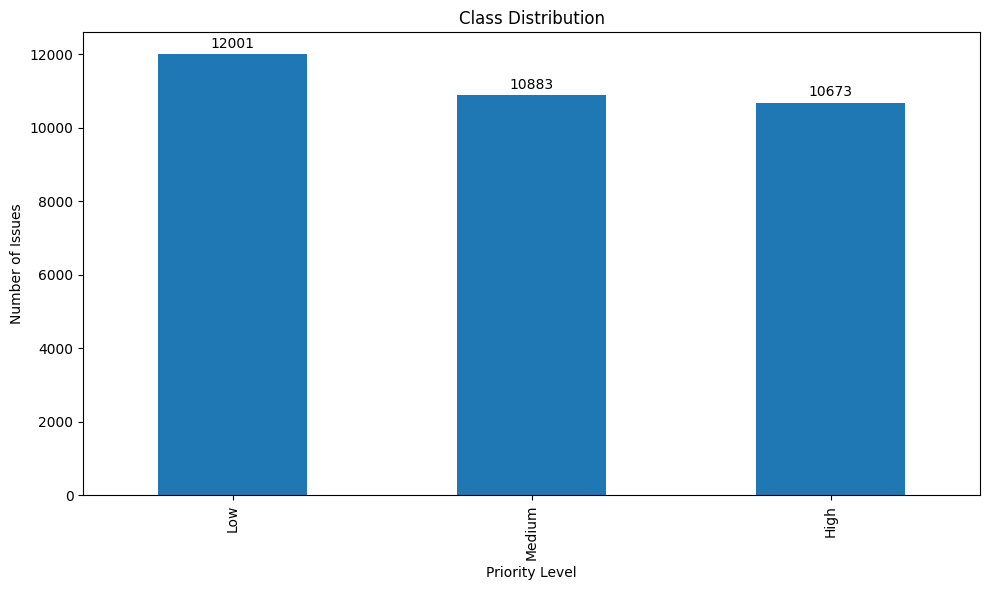

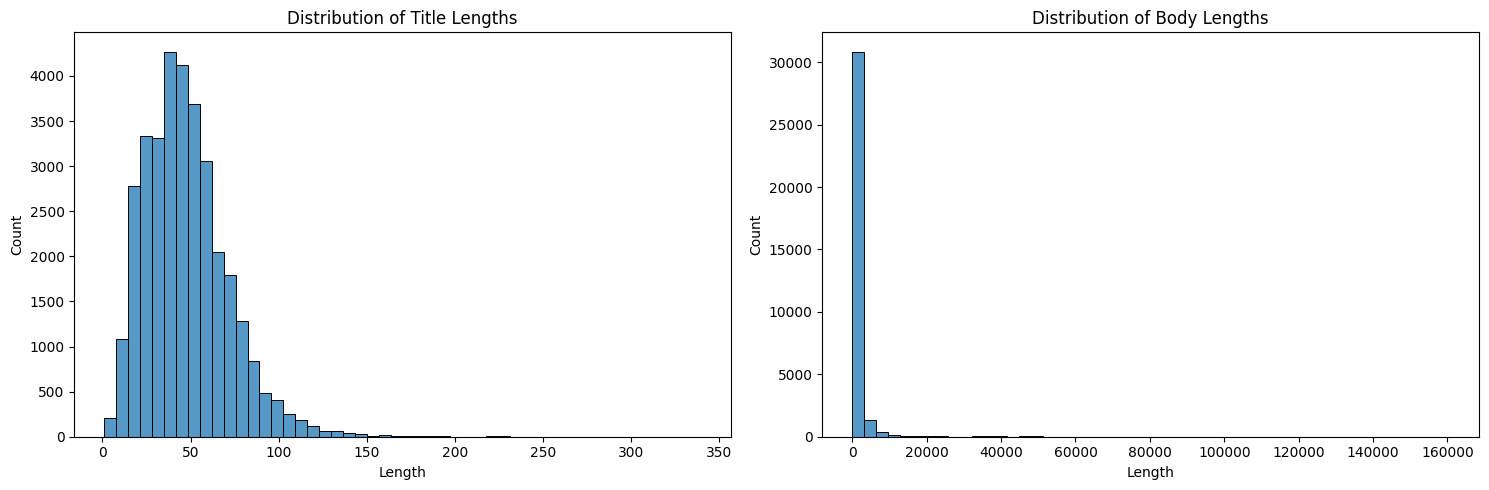

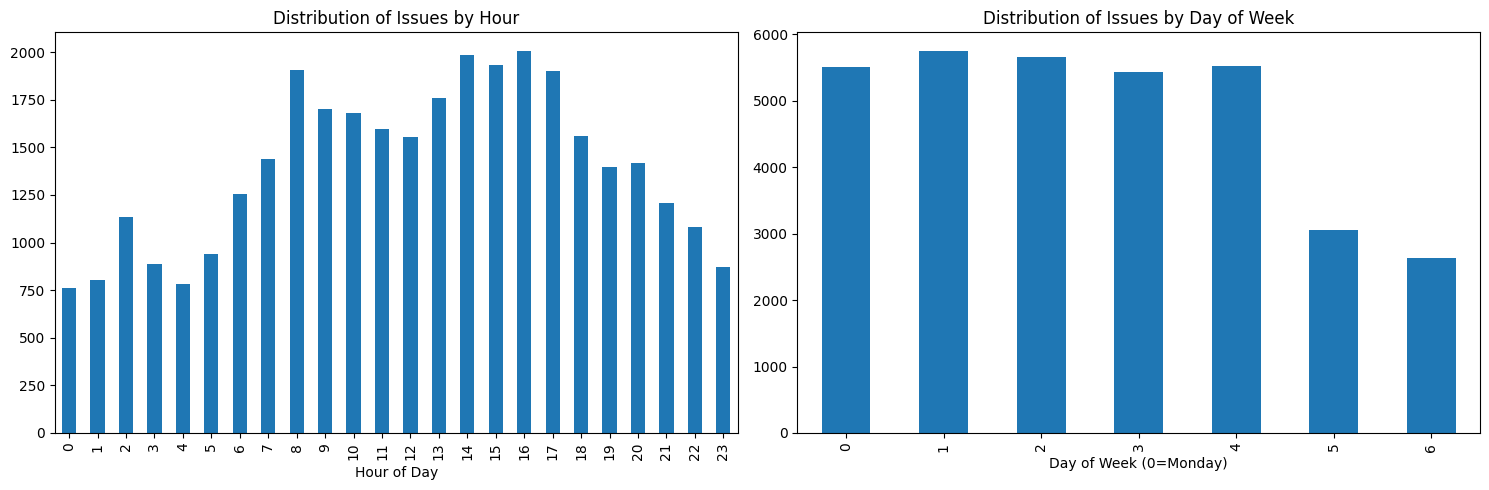

In [ ]:
# Load data
print("Loading data...")
data = pd.read_json('github_issues_with_priority_final.json')

# Analyze dataset
dataset_stats = analyze_dataset(data)

### Preprocess Data

In [ ]:

label_encoder = LabelEncoder()
lemmatizer = WordNetLemmatizer()
best_models = {}
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 3),
    strip_accents='unicode',
    sublinear_tf=True
)

# Preprocess data
X, y = preprocess_data(data)


Starting preprocessing...

Removing missing values...
(The ones that don't have title, body, or priority)
Removed 406 missing values.

Preprocessing text...

Sample cleaned text:

Title:  node_mian.cc use ros::AsyncSpinner instead of ::ros::spin()
Cleaned Title:  node_mian.cc use ros::asyncspinner instead ::ros::spin()

Body:  Hello, Google author:
I have a question ,in node_mian.cc at cartographer_ros, I use ros::AsyncSpinner instead of ::ros::spin()， my code is below
`ros::AsyncSpinner async_spinner(2);
  async_spinner.start();
  ::ros::waitForShutdown();`
The problem is sometimes the project would be crash randomly.

Cleaned Body:  hello, google author: question ,in node_mian.cc cartographer_ros, use ros::asyncspinner instead ::ros::spin() ros::asyncspinner async_spinner(2) async_spinner.start() ::ros::waitforshutdown() sometimes project would crash randomly.

Extracting features...

Vectorizing text...

Scaling numerical features...


### Analyze Preprocessing Results

In [ ]:
preprocess_stats = analyze_preprocessing_results(X, y)


=== Preprocessing Analysis ===
Feature matrix shape: (33151, 10034)
Number of features: 10034

Feature matrix sparsity: 99.29%


### Prepare For Training

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reduce dimensions
X_train_reduced, X_test_reduced = reduce_dimensions(X_train, X_test, 3000)

# Choose best features
print("\nSelecting best features...")
selector = SelectKBest(f_classif, k=3000)
selector.fit(X, y)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


Reducing dimensions...
Explained variance ratio: 0.9490

Selecting best features...


### Run Models

In [ ]:
results = {}

def run_model(model_name):
    # Train with full features
    print(f"\nTraining {model_name} with full features...")
    model = train_model(X_train, y_train, model_name)

    # Plot learning curves
    plot_learning_curves(X_train, y_train, model_name)

    # Analyze feature importance for applicable models
    if model_name in ['decision_tree', 'xgboost']:
        analyze_feature_importance(model_name)

    # Analyze model performance
    results[model_name] = analyze_model(model_name, X_test, y_test)

    # Train with reduced features
    print(f"\nTraining {model_name} with reduced features...")
    model_reduced = train_model(
        X_train_reduced, y_train, f"{model_name}_reduced"
    )

    # Plot learning curves
    plot_learning_curves(X_train_reduced, y_train, f"{model_name}_reduced")

    # Analyze feature importance for applicable models
    if model_name in ['decision_tree', 'xgboost']:
        analyze_feature_importance(f"{model_name}_reduced")

    # Analyze model performance
    results[f"{model_name}_reduced"] = analyze_model(f"{model_name}_reduced", X_test_reduced, y_test)

    return model, model_reduced

#### Decision Tree

In [ ]:
# Load models
model = joblib.load('models/decision_tree_model.pkl')
model_reduced = joblib.load('models/decision_tree_model_reduced.pkl')

best_models['decision_tree'] = model
best_models['decision_tree_reduced'] = model_reduced

results['decision_tree'] = analyze_model('decision_tree', X_test, y_test)
results['decision_tree_reduced'] = analyze_model('decision_tree_reduced', X_test_reduced, y_test)


Training decision_tree with full features...

Training decision_tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 50}


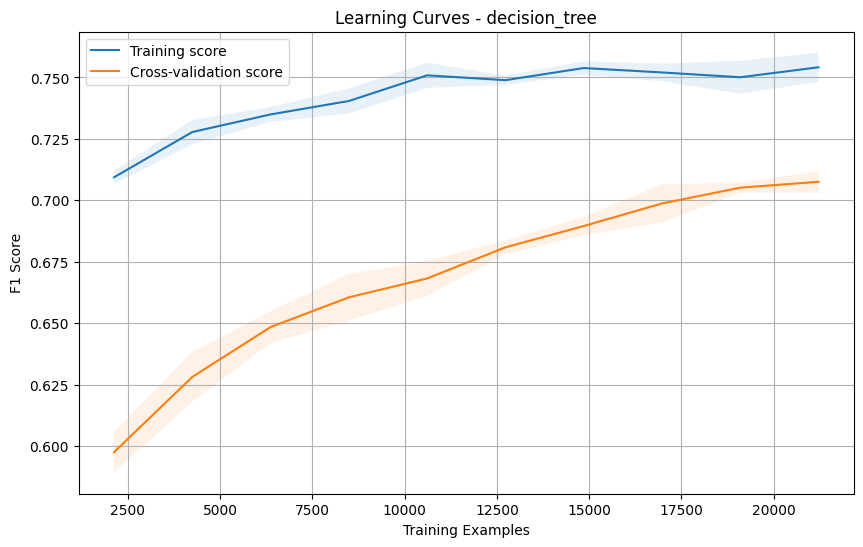

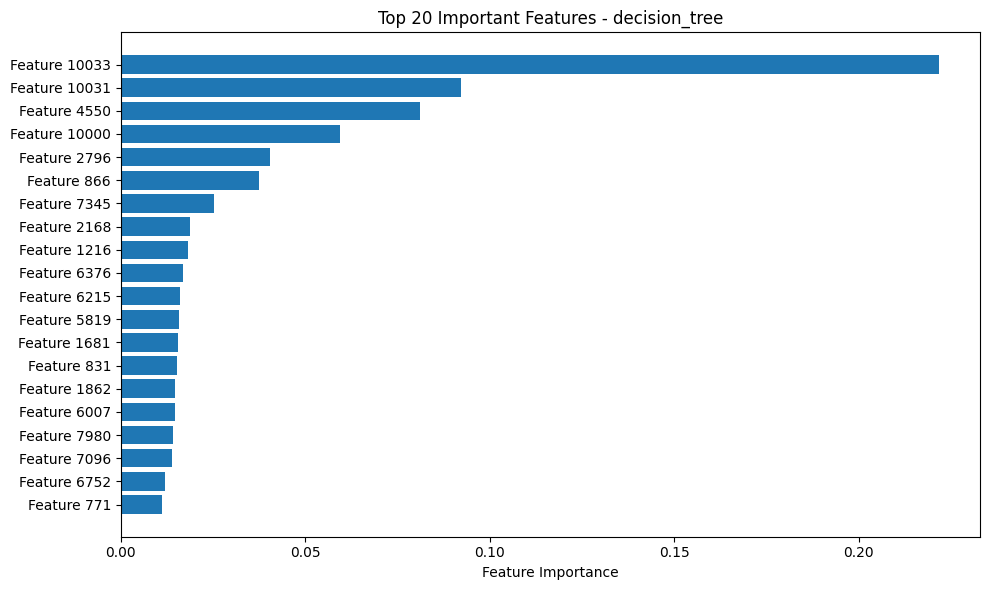


Classification Report:
              precision    recall  f1-score   support

        High       0.65      0.74      0.69      2126
         Low       0.74      0.75      0.74      2382
      Medium       0.77      0.65      0.70      2123

    accuracy                           0.71      6631
   macro avg       0.72      0.71      0.71      6631
weighted avg       0.72      0.71      0.71      6631



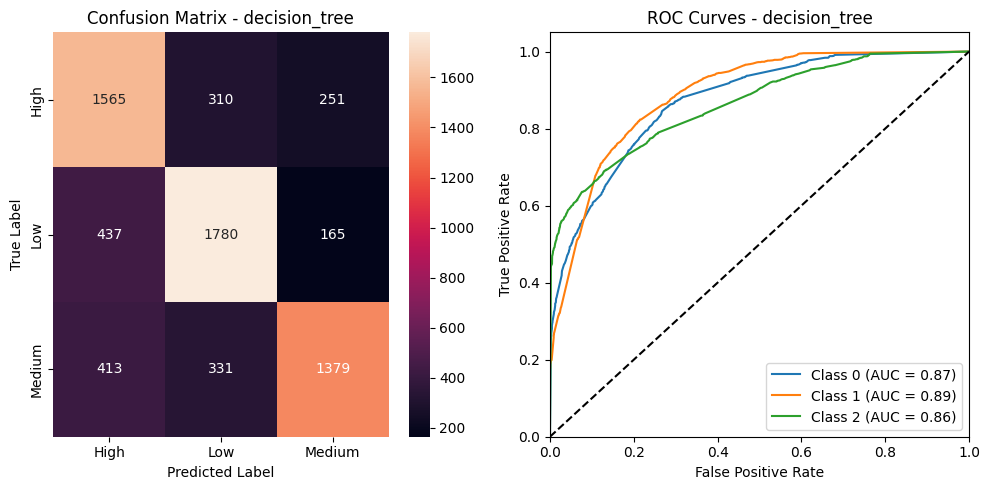


Training decision_tree with reduced features...

Training decision_tree_reduced...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 100}


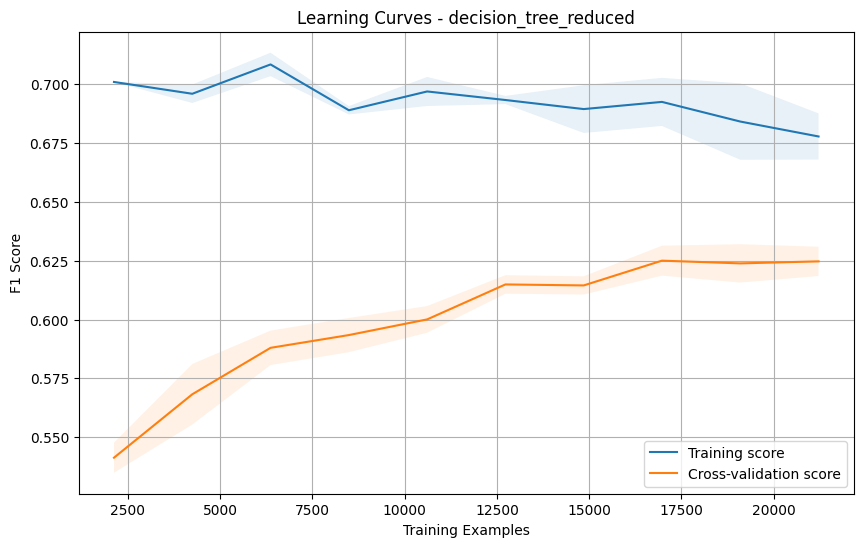

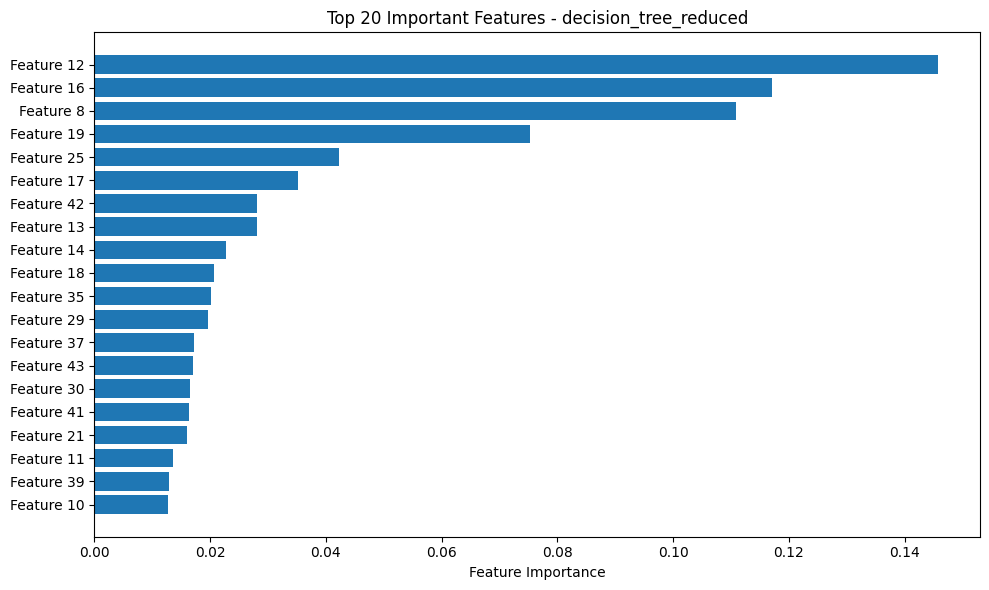


Classification Report:
              precision    recall  f1-score   support

        High       0.56      0.68      0.61      2126
         Low       0.62      0.67      0.64      2382
      Medium       0.77      0.54      0.64      2123

    accuracy                           0.63      6631
   macro avg       0.65      0.63      0.63      6631
weighted avg       0.65      0.63      0.63      6631



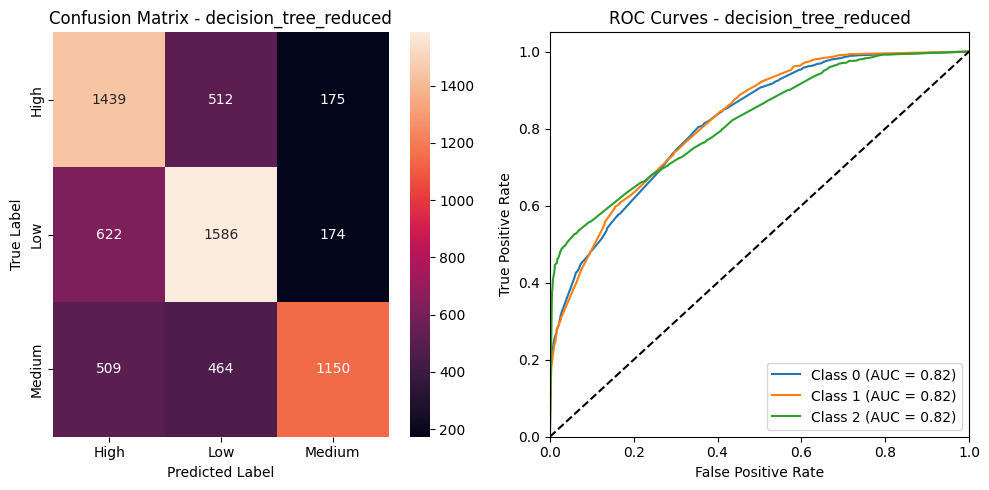

['models/decision_tree_model_reduced.pkl']

In [ ]:
model, model_reduced = run_model('decision_tree')

# Save models
joblib.dump(model, 'models/decision_tree_model.pkl')
joblib.dump(model_reduced, 'models/decision_tree_model_reduced.pkl')

#### KNN

In [ ]:
# Load models
model = joblib.load('models/knn_model.pkl')
model_reduced = joblib.load('models/knn_model_reduced.pkl')

best_models['knn'] = model
best_models['knn_reduced'] = model_reduced

results['knn'] = analyze_model('knn', X_test, y_test)
results['knn_reduced'] = analyze_model('knn_reduced', X_test_reduced, y_test)


Training knn with full features...

Training knn...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}


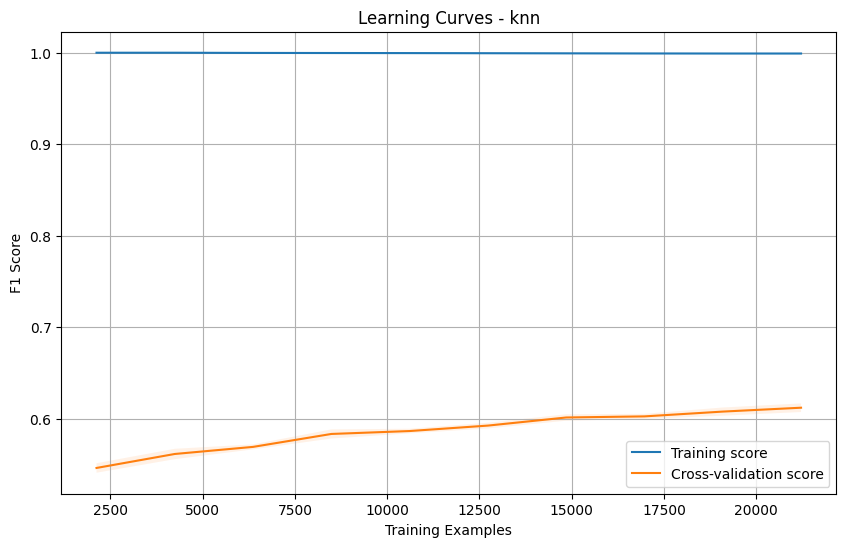


Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.41      0.53      2126
         Low       0.52      0.90      0.66      2382
      Medium       0.87      0.55      0.67      2123

    accuracy                           0.63      6631
   macro avg       0.72      0.62      0.62      6631
weighted avg       0.71      0.63      0.62      6631



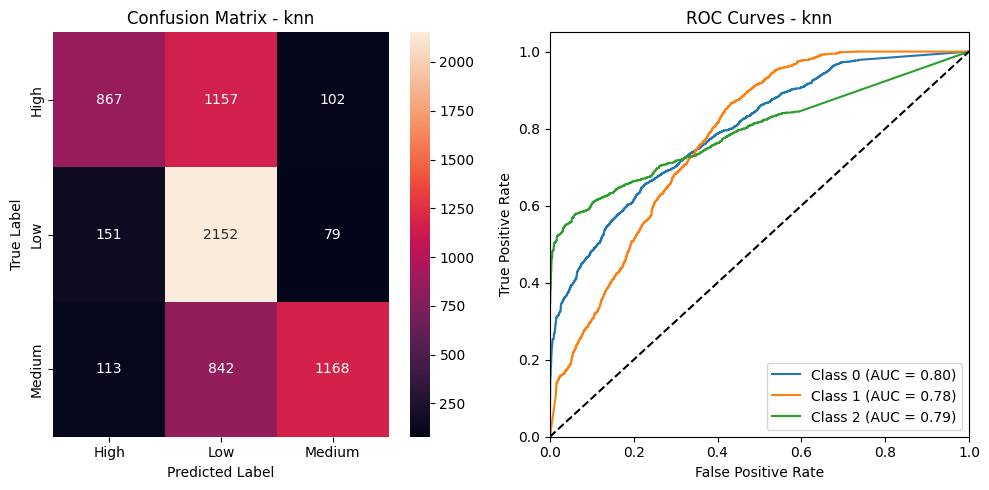


Training knn with reduced features...

Training knn_reduced...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}


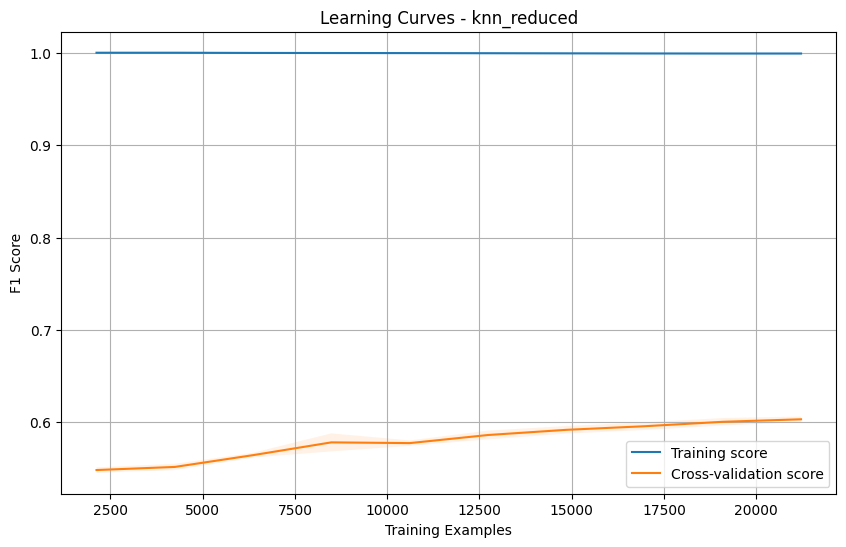


Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.38      0.52      2126
         Low       0.51      0.94      0.66      2382
      Medium       0.89      0.52      0.66      2123

    accuracy                           0.63      6631
   macro avg       0.73      0.61      0.61      6631
weighted avg       0.72      0.63      0.61      6631



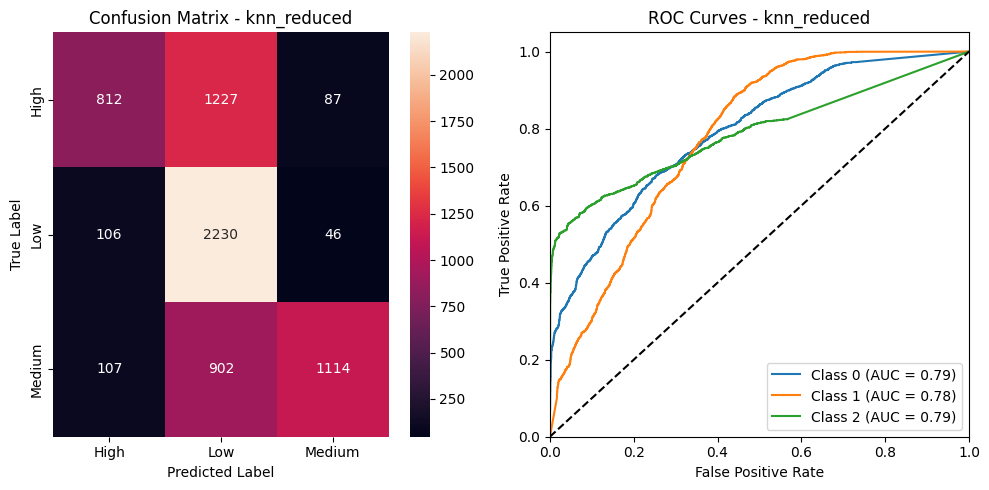

['models/knn_model_reduced.pkl']

In [ ]:
model, model_reduced = run_model('knn')

# Save models
joblib.dump(model, 'models/knn_model.pkl')
joblib.dump(model_reduced, 'models/knn_model_reduced.pkl')

#### Naive Bayes

In [ ]:
# Load models
model = joblib.load('models/naive_bayes_model.pkl')
model_reduced = joblib.load('models/naive_bayes_model_reduced.pkl')

best_models['naive_bayes'] = model
best_models['naive_bayes_reduced'] = model_reduced

results['naive_bayes'] = analyze_model('naive_bayes', X_test, y_test)
results['naive_bayes_reduced'] = analyze_model('naive_bayes_reduced', X_test_reduced, y_test)


Training naive_bayes with full features...

Training naive_bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters: {'alpha': 0.01}


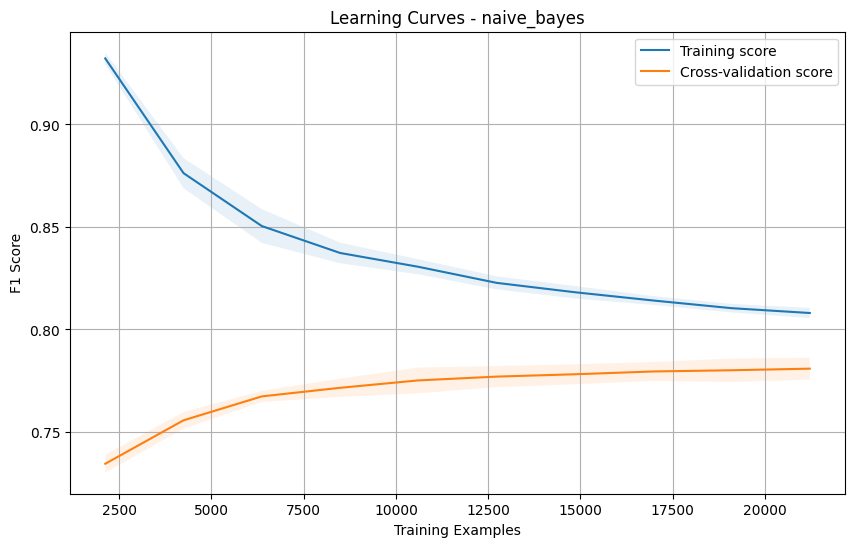


Classification Report:
              precision    recall  f1-score   support

        High       0.73      0.84      0.78      2126
         Low       0.75      0.88      0.81      2382
      Medium       0.96      0.63      0.76      2123

    accuracy                           0.79      6631
   macro avg       0.81      0.78      0.78      6631
weighted avg       0.81      0.79      0.78      6631



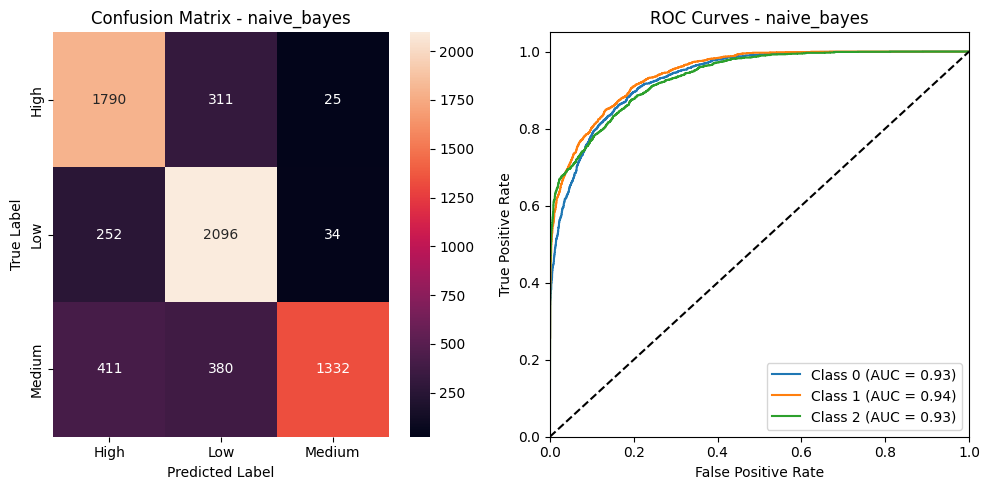


Training naive_bayes with reduced features...

Training naive_bayes_reduced...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters: {'alpha': 0.01}


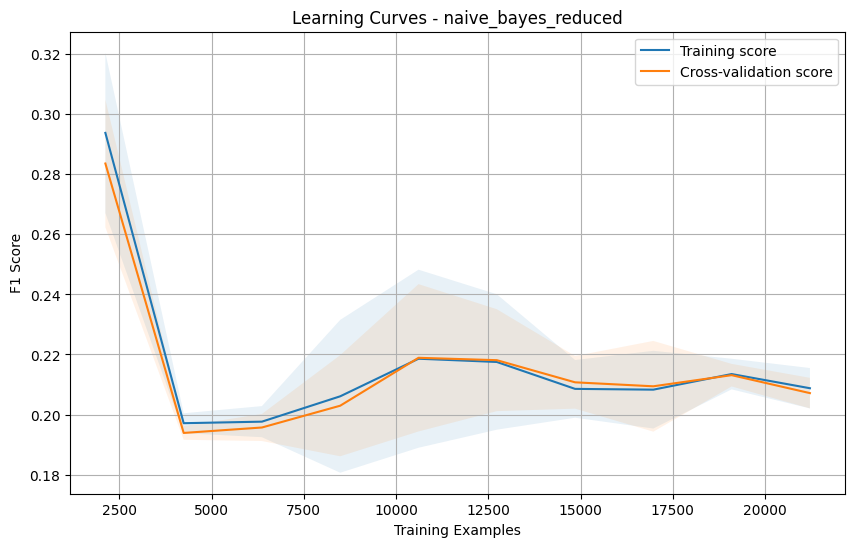


Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.00      0.00      2126
         Low       0.36      1.00      0.53      2382
      Medium       1.00      0.03      0.05      2123

    accuracy                           0.37      6631
   macro avg       0.79      0.34      0.20      6631
weighted avg       0.77      0.37      0.21      6631



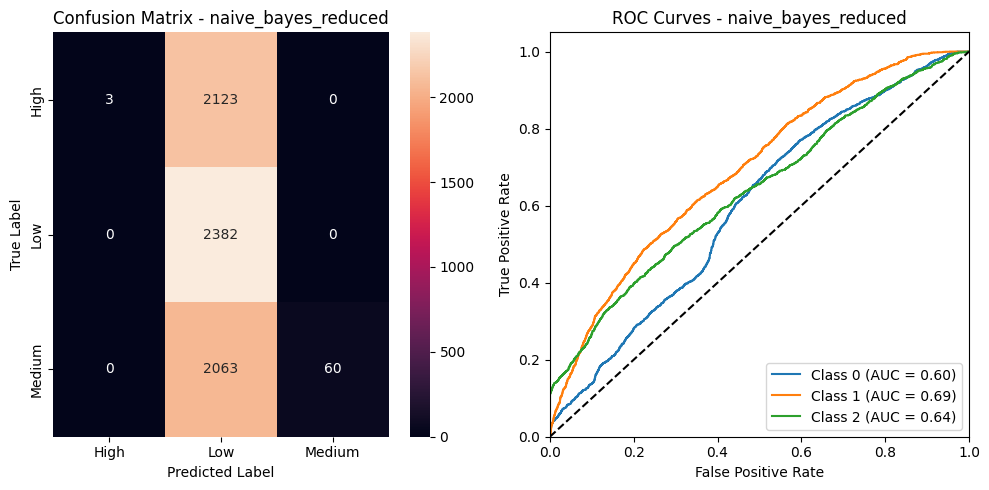

['models/naive_bayes_model_reduced.pkl']

In [ ]:
model, model_reduced = run_model('naive_bayes')

# Save models
joblib.dump(model, 'models/naive_bayes_model.pkl')
joblib.dump(model_reduced, 'models/naive_bayes_model_reduced.pkl')

#### SVM Linear


Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.83      0.80      2126
         Low       0.83      0.84      0.84      2382
      Medium       0.87      0.79      0.83      2123

    accuracy                           0.82      6631
   macro avg       0.82      0.82      0.82      6631
weighted avg       0.82      0.82      0.82      6631



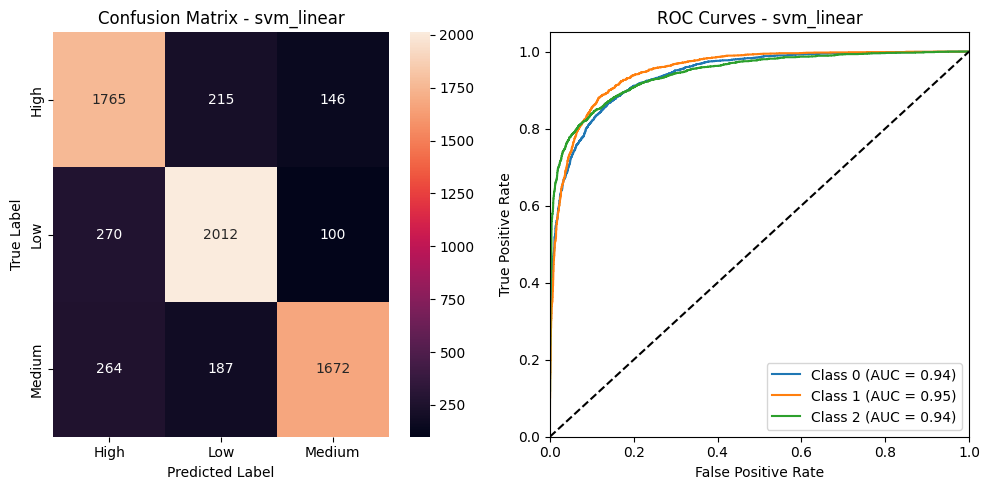


Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.83      0.80      2126
         Low       0.83      0.84      0.83      2382
      Medium       0.86      0.78      0.82      2123

    accuracy                           0.82      6631
   macro avg       0.82      0.82      0.82      6631
weighted avg       0.82      0.82      0.82      6631



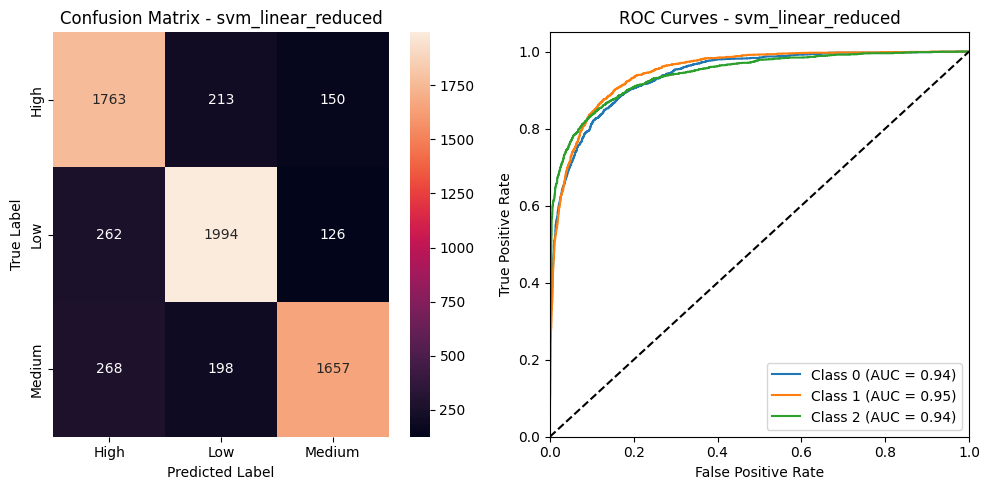

In [ ]:
# Load models
model = joblib.load('models/svm_linear_model.pkl')
model_reduced = joblib.load('models/svm_linear_model_reduced.pkl')

best_models['svm_linear'] = model
best_models['svm_linear_reduced'] = model_reduced

results['svm_linear'] = analyze_model('svm_linear', X_test, y_test)
results['svm_linear_reduced'] = analyze_model('svm_linear_reduced', X_test_reduced, y_test)


Training svm_linear with full features...

Training svm_linear...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best parameters: {'C': 1.0, 'class_weight': 'balanced'}


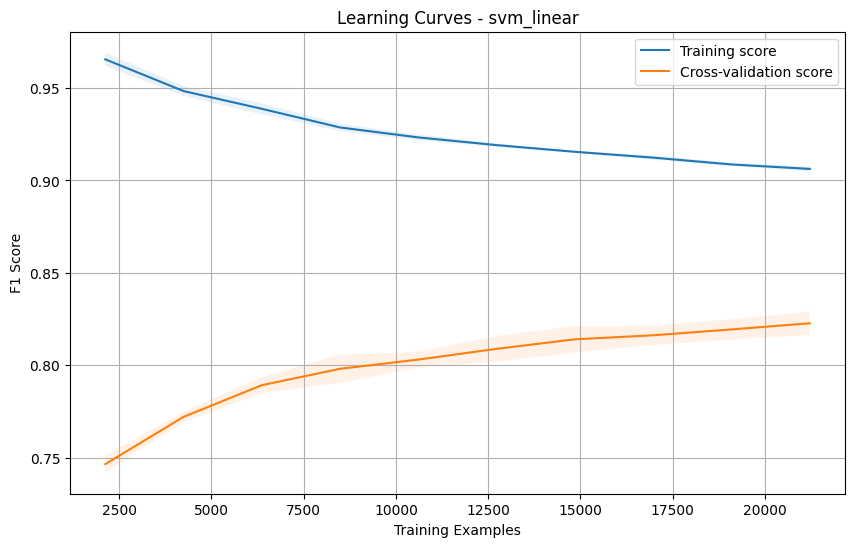


Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.83      0.80      2126
         Low       0.83      0.84      0.84      2382
      Medium       0.87      0.79      0.83      2123

    accuracy                           0.82      6631
   macro avg       0.82      0.82      0.82      6631
weighted avg       0.82      0.82      0.82      6631



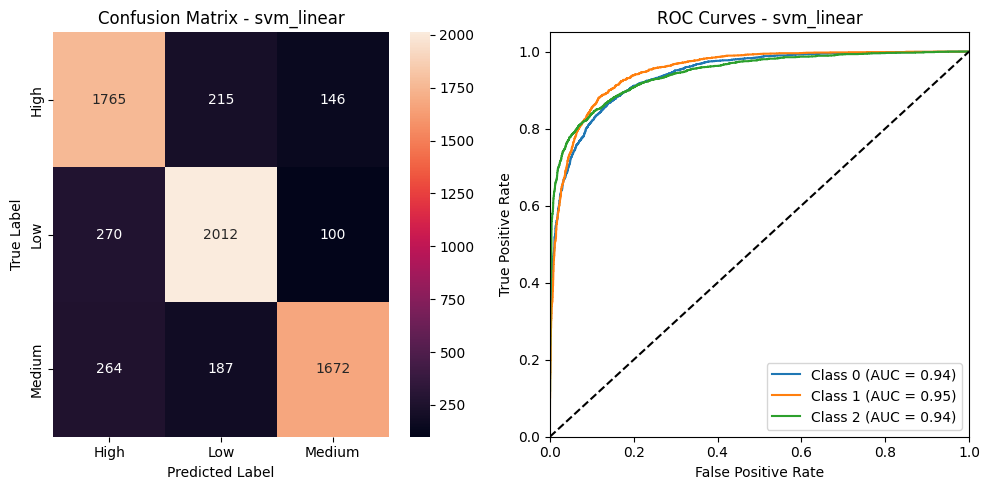


Training svm_linear with reduced features...

Training svm_linear_reduced...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best parameters: {'C': 1.0, 'class_weight': 'balanced'}


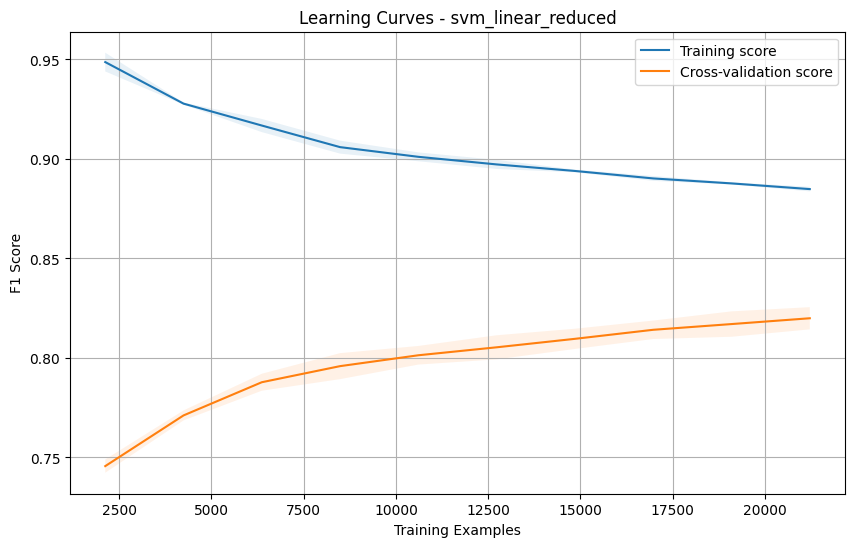


Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.83      0.80      2126
         Low       0.83      0.84      0.83      2382
      Medium       0.86      0.78      0.82      2123

    accuracy                           0.82      6631
   macro avg       0.82      0.82      0.82      6631
weighted avg       0.82      0.82      0.82      6631



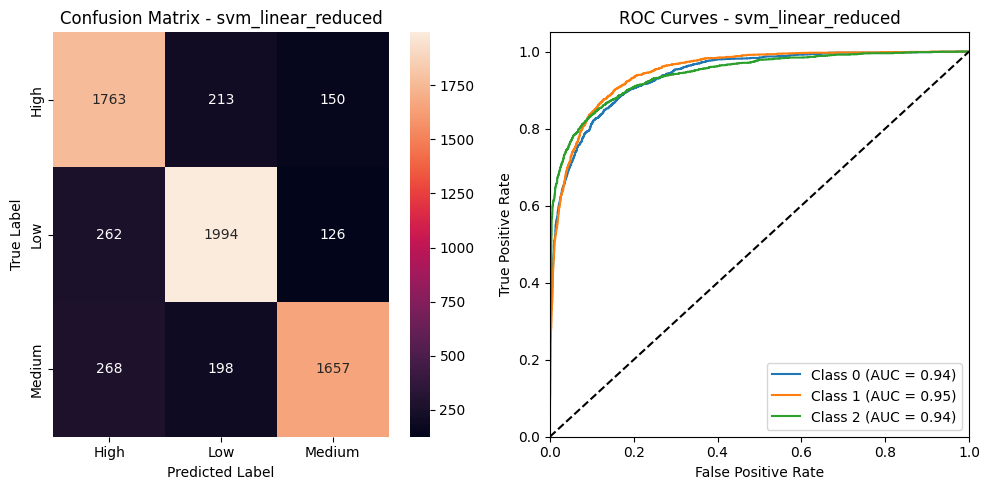

['models/svm_linear_model_reduced.pkl']

In [ ]:
model, model_reduced = run_model('svm_linear')

# Save models
joblib.dump(model, 'models/svm_linear_model.pkl')
joblib.dump(model_reduced, 'models/svm_linear_model_reduced.pkl')

#### SVM RBF


Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.83      0.81      2126
         Low       0.84      0.86      0.85      2382
      Medium       0.86      0.80      0.82      2123

    accuracy                           0.83      6631
   macro avg       0.83      0.83      0.83      6631
weighted avg       0.83      0.83      0.83      6631



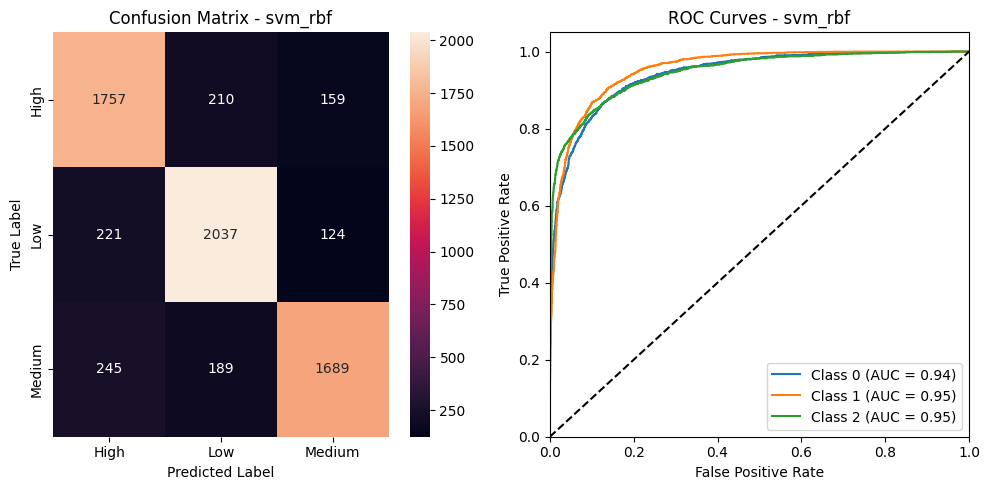


Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.81      0.80      2126
         Low       0.82      0.86      0.84      2382
      Medium       0.87      0.79      0.83      2123

    accuracy                           0.82      6631
   macro avg       0.82      0.82      0.82      6631
weighted avg       0.82      0.82      0.82      6631



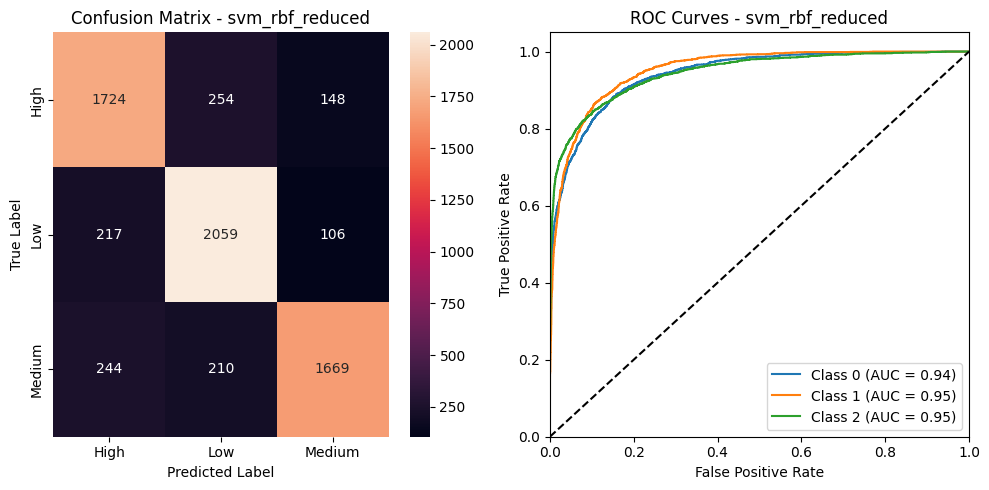

In [ ]:
# Load models
model = joblib.load('models/svm_rbf_model.pkl')
model_reduced = joblib.load('models/svm_rbf_model_reduced.pkl')

best_models['svm_rbf'] = model
best_models['svm_rbf_reduced'] = model_reduced

results['svm_rbf'] = analyze_model('svm_rbf', X_test, y_test)
results['svm_rbf_reduced'] = analyze_model('svm_rbf_reduced', X_test_reduced, y_test)


Training svm_rbf with full features...

Training svm_rbf...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 10.0, 'class_weight': 'balanced', 'gamma': 'scale'}


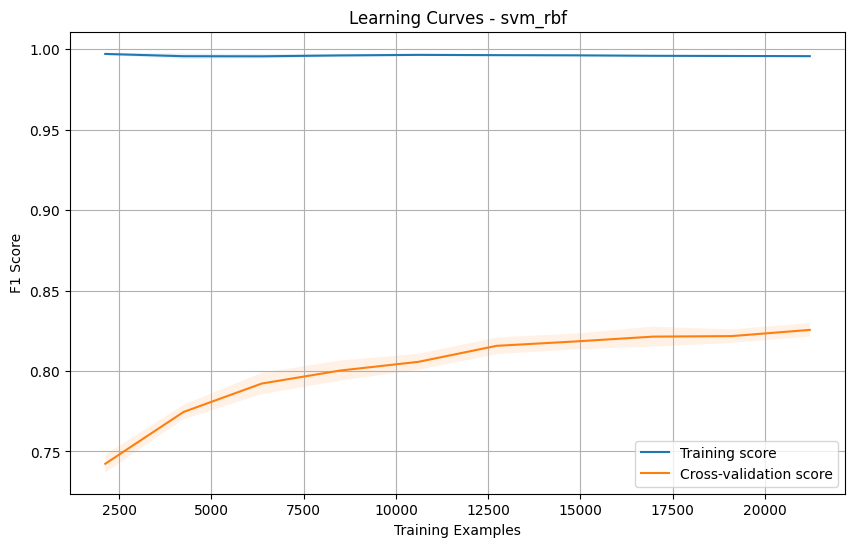


Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.83      0.81      2126
         Low       0.84      0.86      0.85      2382
      Medium       0.86      0.80      0.82      2123

    accuracy                           0.83      6631
   macro avg       0.83      0.83      0.83      6631
weighted avg       0.83      0.83      0.83      6631



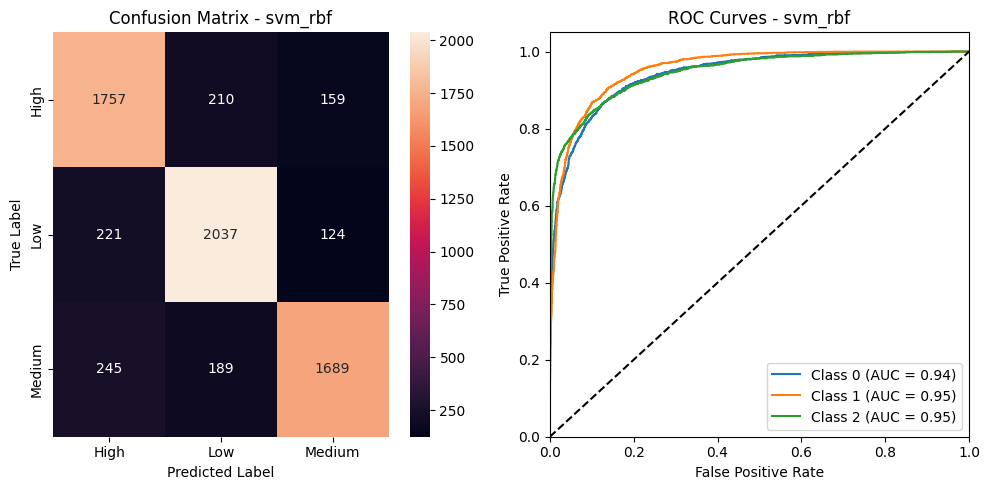


Training svm_rbf with reduced features...

Training svm_rbf_reduced...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 10.0, 'class_weight': 'balanced', 'gamma': 'scale'}


KeyboardInterrupt: 

In [ ]:
model, model_reduced = run_model('svm_rbf')

# Save models
joblib.dump(model, 'models/svm_rbf_model.pkl')
joblib.dump(model_reduced, 'models/svm_rbf_model_reduced.pkl')

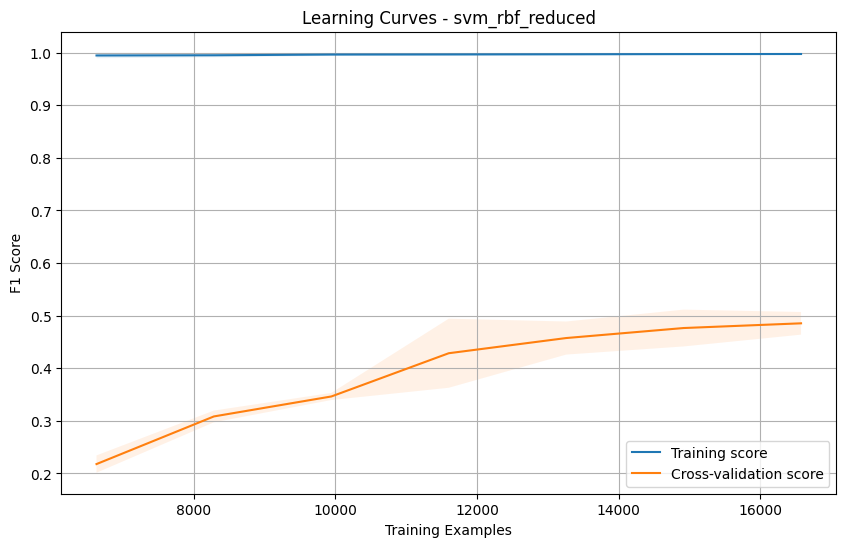

In [ ]:
model = best_models['svm_rbf_reduced']
train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=2, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_weighted'
    )

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title(f'Learning Curves - svm_rbf_reduced')
plt.legend(loc='best')
plt.grid()
plt.show()

# # Analyze model performance
# results[f"svm_rbf_reduced"] = analyze_model(f"svm_rbf_reduced", X_test_reduced, y_test)

In [ ]:
joblib.dump(best_models["svm_rbf"], 'models/svm_rbf_model.pkl')
joblib.dump(best_models["svm_rbf_reduced"], 'models/svm_rbf_model_reduced.pkl')

['models/svm_rbf_model_reduced.pkl']

#### XGBoost


Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.84      0.81      2126
         Low       0.80      0.89      0.84      2382
      Medium       0.92      0.76      0.83      2123

    accuracy                           0.83      6631
   macro avg       0.84      0.83      0.83      6631
weighted avg       0.84      0.83      0.83      6631



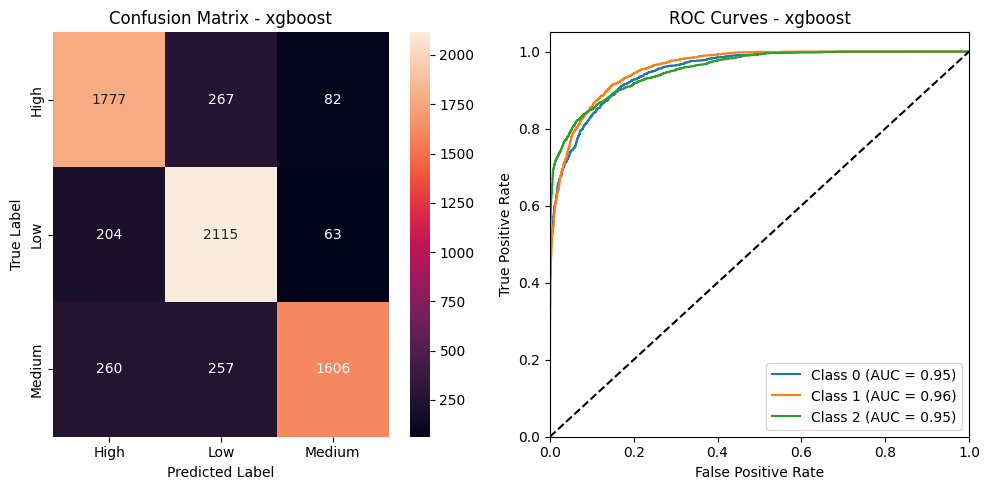


Classification Report:
              precision    recall  f1-score   support

        High       0.75      0.79      0.77      2126
         Low       0.76      0.84      0.80      2382
      Medium       0.86      0.71      0.78      2123

    accuracy                           0.78      6631
   macro avg       0.79      0.78      0.78      6631
weighted avg       0.79      0.78      0.78      6631



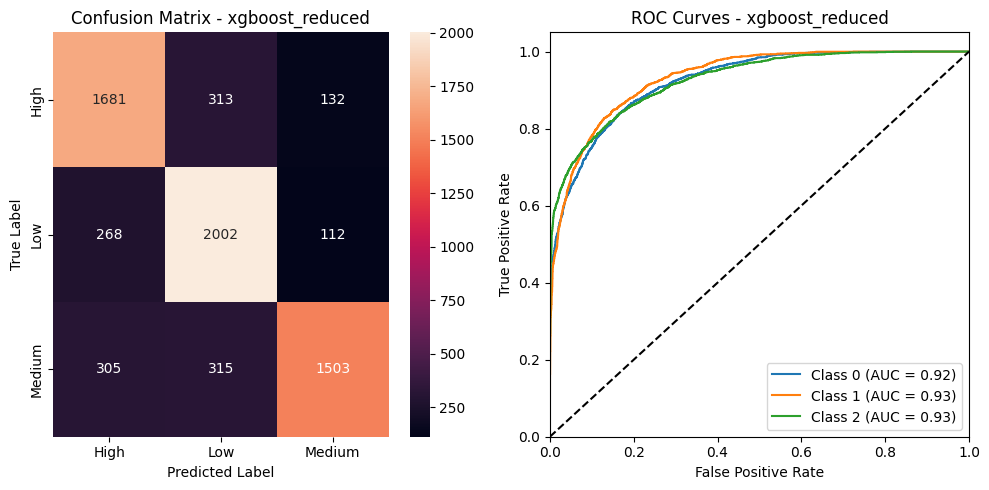

In [ ]:
# Load models
model = joblib.load('models/xgboost_model.pkl')
model_reduced = joblib.load('models/xgboost_model_reduced.pkl')

best_models['xgboost'] = model
best_models['xgboost_reduced'] = model_reduced

results['xgboost'] = analyze_model('xgboost', X_test, y_test)
results['xgboost_reduced'] = analyze_model('xgboost_reduced', X_test_reduced, y_test)


Training xgboost with full features...

Training xgboost...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


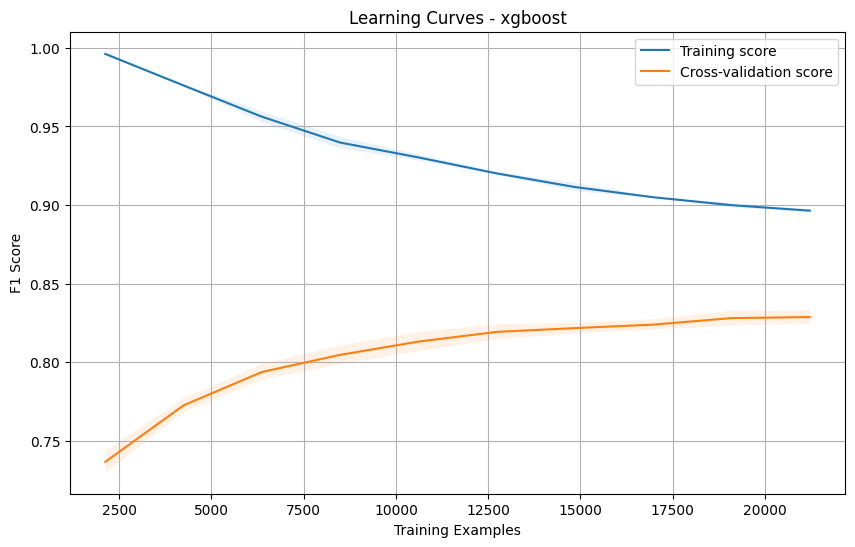

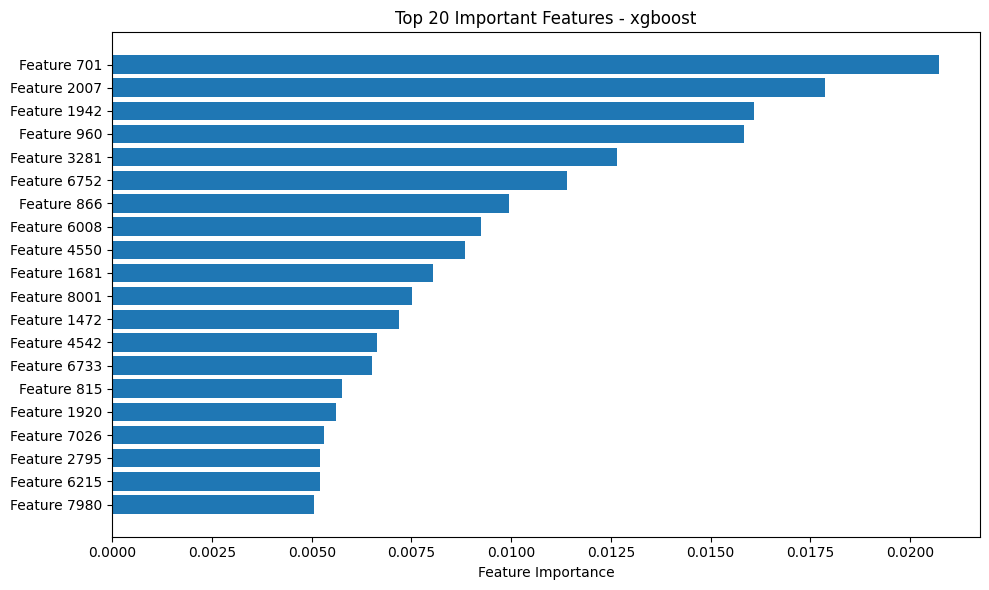


Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.84      0.81      2126
         Low       0.80      0.89      0.84      2382
      Medium       0.92      0.76      0.83      2123

    accuracy                           0.83      6631
   macro avg       0.84      0.83      0.83      6631
weighted avg       0.84      0.83      0.83      6631



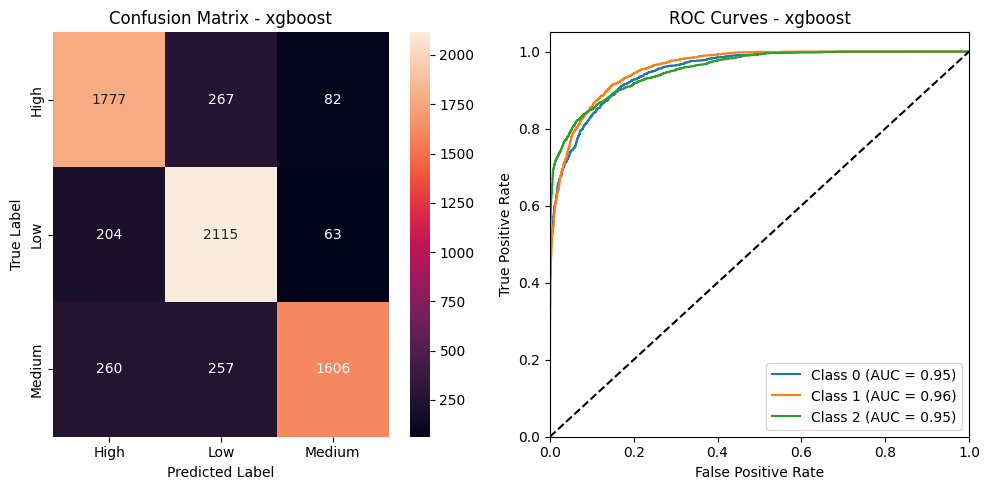


Training xgboost with reduced features...

Training xgboost_reduced...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9}


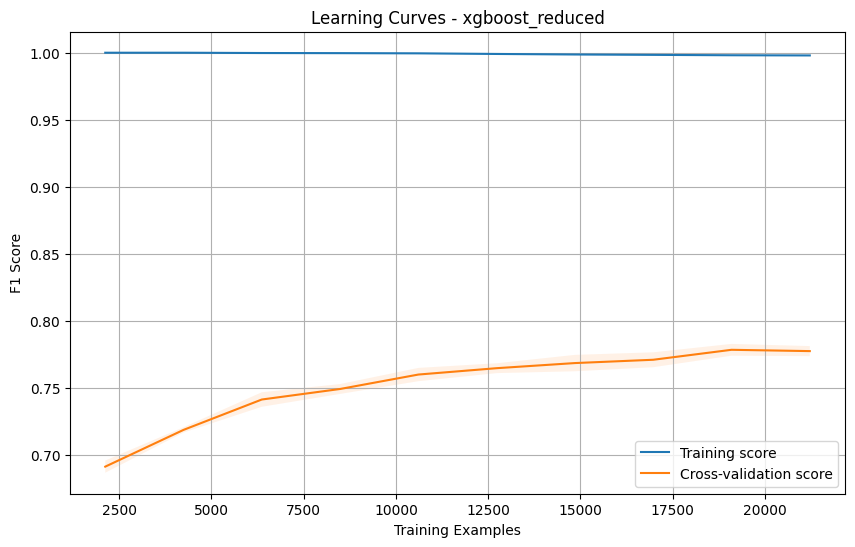

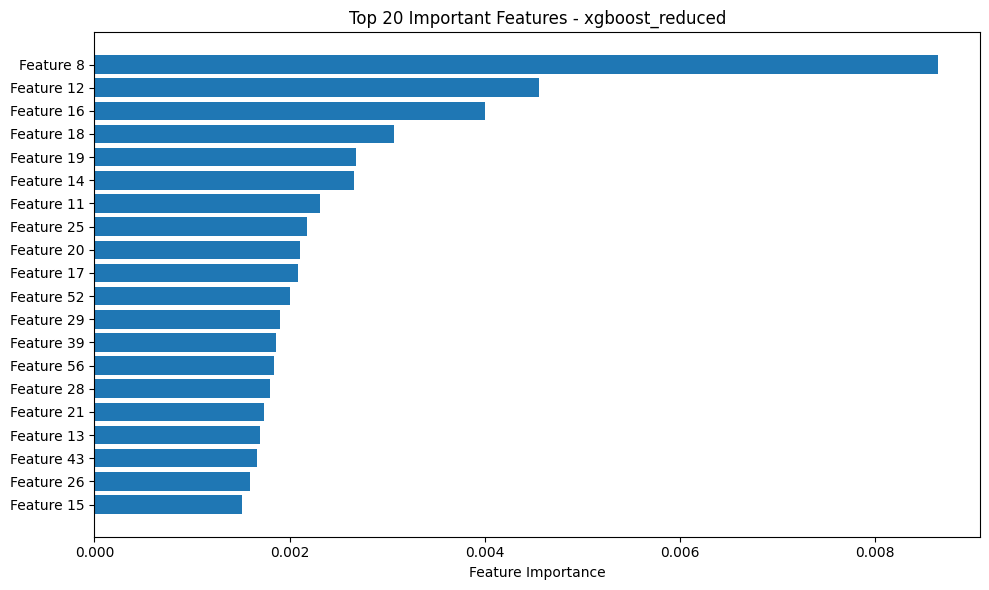


Classification Report:
              precision    recall  f1-score   support

        High       0.75      0.79      0.77      2126
         Low       0.76      0.84      0.80      2382
      Medium       0.86      0.71      0.78      2123

    accuracy                           0.78      6631
   macro avg       0.79      0.78      0.78      6631
weighted avg       0.79      0.78      0.78      6631



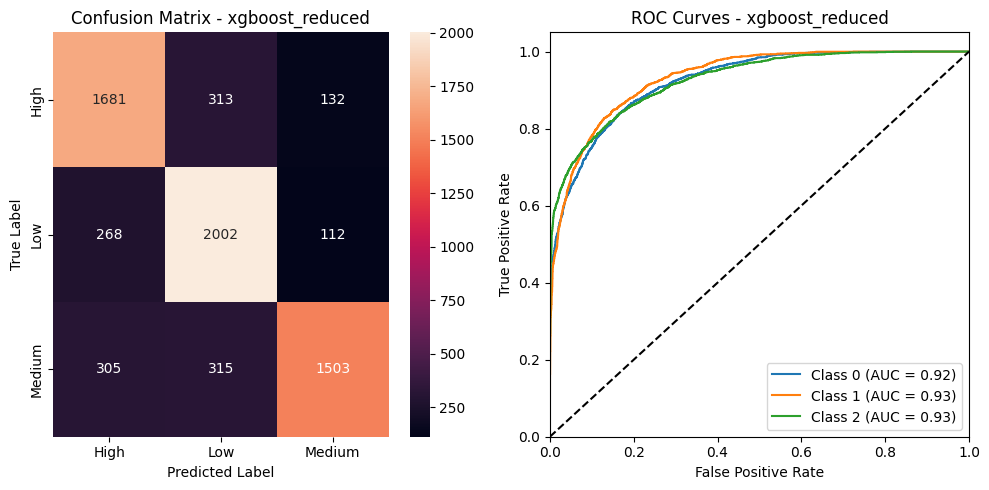

['models/xgboost_model_reduced.pkl']

In [ ]:
model, model_reduced = run_model('xgboost')

# Save models
joblib.dump(model, 'models/xgboost_model.pkl')
joblib.dump(model_reduced, 'models/xgboost_model_reduced.pkl')

#### Compare Models

<Figure size 3200x800 with 0 Axes>

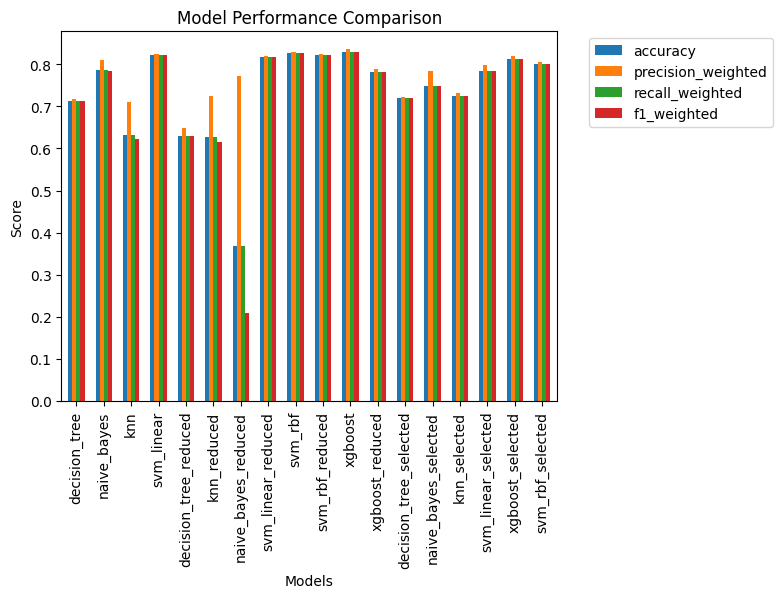


Model Comparison:
                        accuracy  precision_weighted  recall_weighted  \
decision_tree           0.712411            0.717845         0.712411   
naive_bayes             0.786910            0.810699         0.786910   
knn                     0.631428            0.709213         0.631428   
svm_linear              0.821746            0.824645         0.821746   
decision_tree_reduced   0.629618            0.647517         0.629618   
knn_reduced             0.626753            0.723778         0.626753   
naive_bayes_reduced     0.368723            0.771056         0.368723   
svm_linear_reduced      0.816468            0.818791         0.816468   
svm_rbf                 0.826874            0.828006         0.826874   
svm_rbf_reduced         0.822199            0.824003         0.822199   
xgboost                 0.829136            0.835777         0.829136   
xgboost_reduced         0.782084            0.788002         0.782084   
decision_tree_selected  0.719801

In [ ]:
# Compare models
comparison_df = compare_models(results)
print("\nModel Comparison:")
print(comparison_df)

## Feature Selection


Training decision_tree_selected with full features...

Training decision_tree_selected...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 25, 'min_samples_leaf': 20, 'min_samples_split': 50}


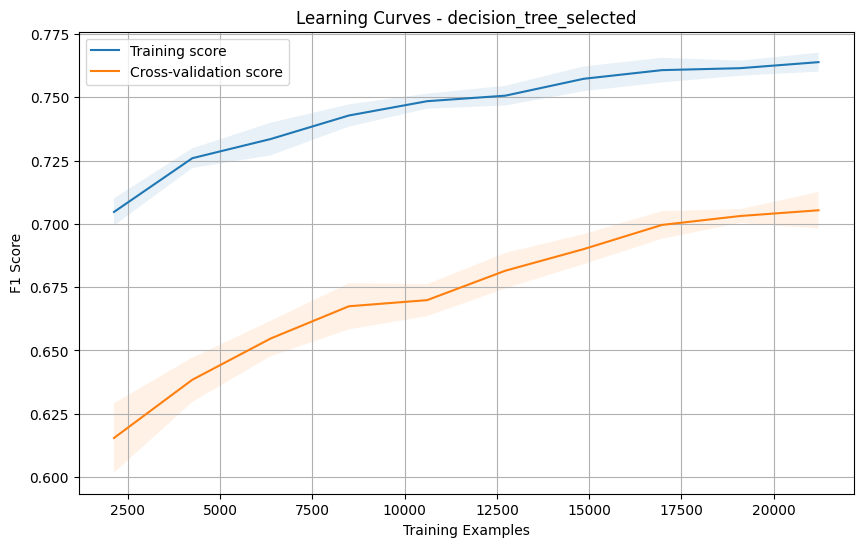


Classification Report:
              precision    recall  f1-score   support

        High       0.67      0.72      0.70      2126
         Low       0.73      0.77      0.75      2382
      Medium       0.77      0.66      0.71      2123

    accuracy                           0.72      6631
   macro avg       0.72      0.72      0.72      6631
weighted avg       0.72      0.72      0.72      6631



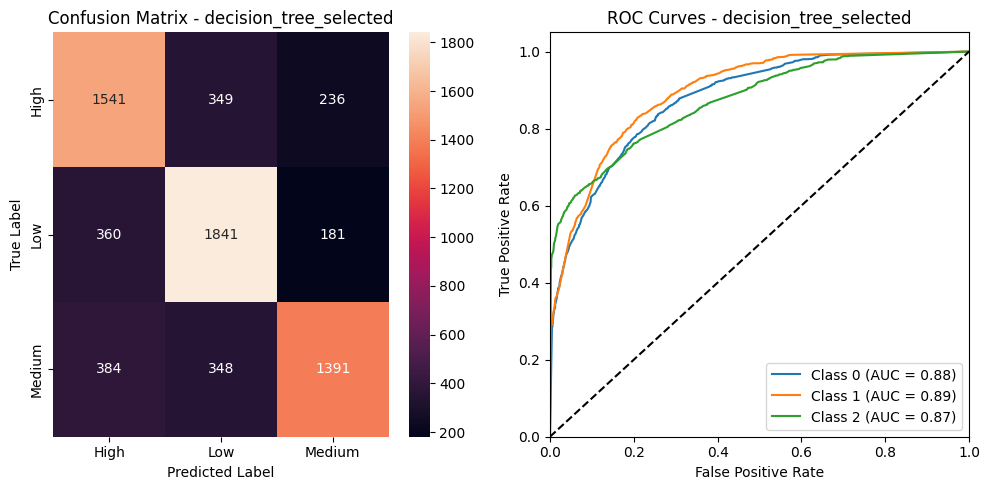

In [ ]:
model_name = 'decision_tree_selected'

# Train with full features
print(f"\nTraining {model_name} with full features...")
model = train_model(X_train_selected, y_train, model_name)

# Plot learning curves
plot_learning_curves(X_train_selected, y_train, model_name)

# Analyze feature importance for applicable models
if model_name in ['decision_tree_selected', 'xgboost']:
    analyze_feature_importance(model_name)

# Analyze model performance
results[model_name] = analyze_model(model_name, X_test_selected, y_test)


Training naive_bayes_selected with full features...

Training naive_bayes_selected...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters: {'alpha': 0.01}


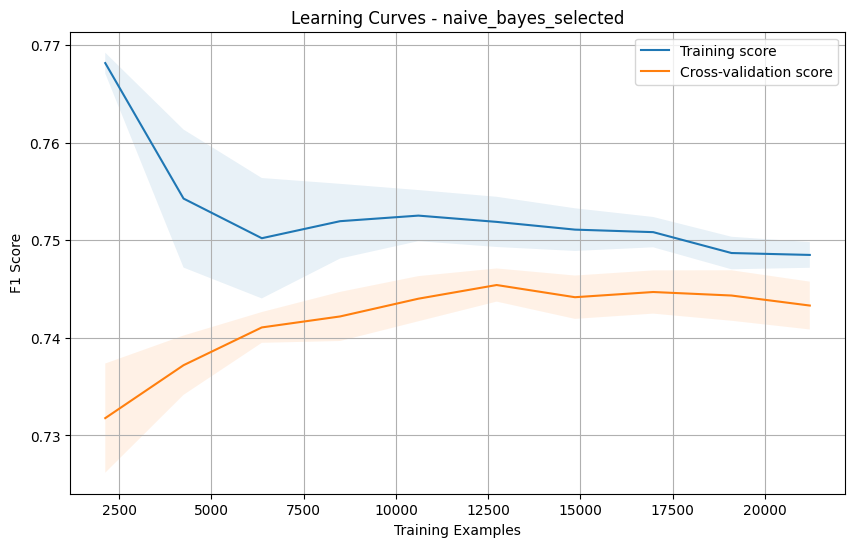


Classification Report:
              precision    recall  f1-score   support

        High       0.74      0.72      0.73      2126
         Low       0.66      0.89      0.76      2382
      Medium       0.96      0.61      0.75      2123

    accuracy                           0.75      6631
   macro avg       0.79      0.74      0.75      6631
weighted avg       0.78      0.75      0.75      6631



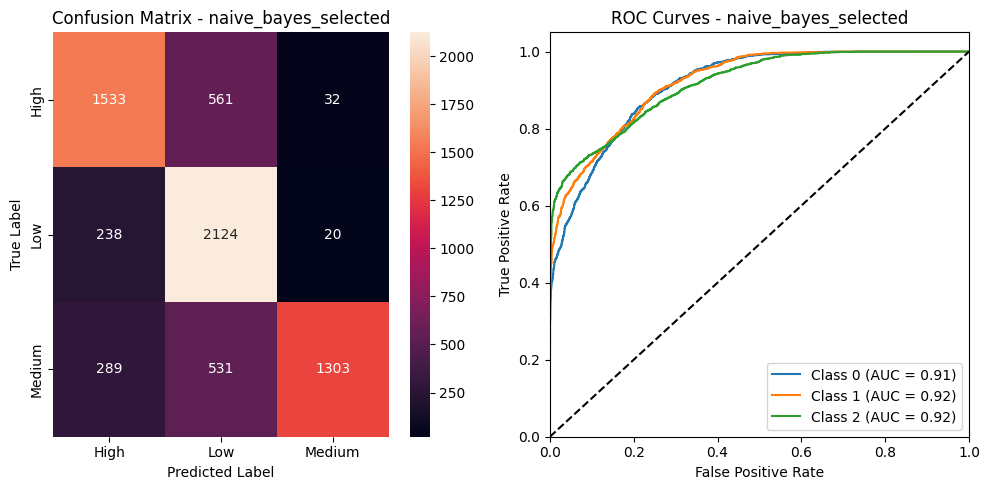

In [ ]:
model_name = 'naive_bayes_selected'

# Train with full features
print(f"\nTraining {model_name} with full features...")
model = train_model(X_train_selected, y_train, model_name)

# Plot learning curves
plot_learning_curves(X_train_selected, y_train, model_name)

# Analyze feature importance for applicable models
if model_name in ['decision_tree', 'xgboost']:
    analyze_feature_importance(model_name)

# Analyze model performance
results[model_name] = analyze_model(model_name, X_test_selected, y_test)


Training knn_selected with full features...

Training knn_selected...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}


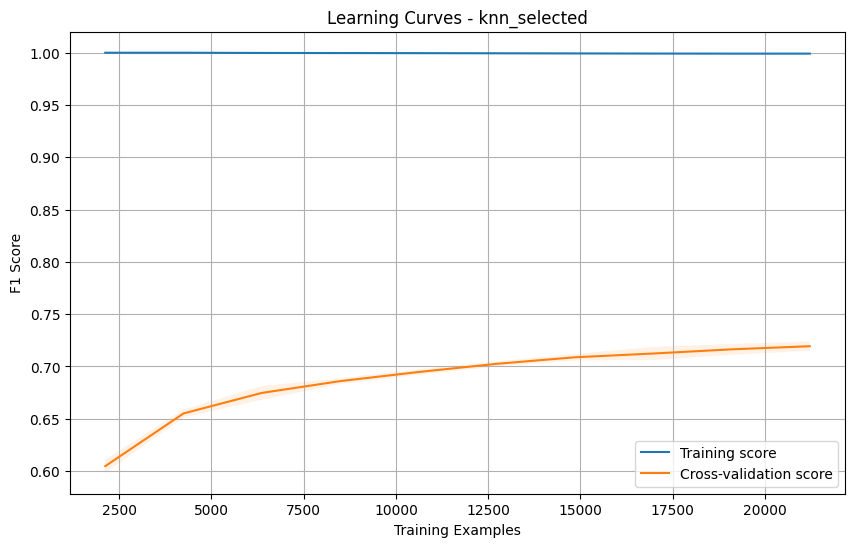


Classification Report:
              precision    recall  f1-score   support

        High       0.71      0.71      0.71      2126
         Low       0.67      0.78      0.72      2382
      Medium       0.82      0.69      0.75      2123

    accuracy                           0.72      6631
   macro avg       0.73      0.72      0.73      6631
weighted avg       0.73      0.72      0.73      6631



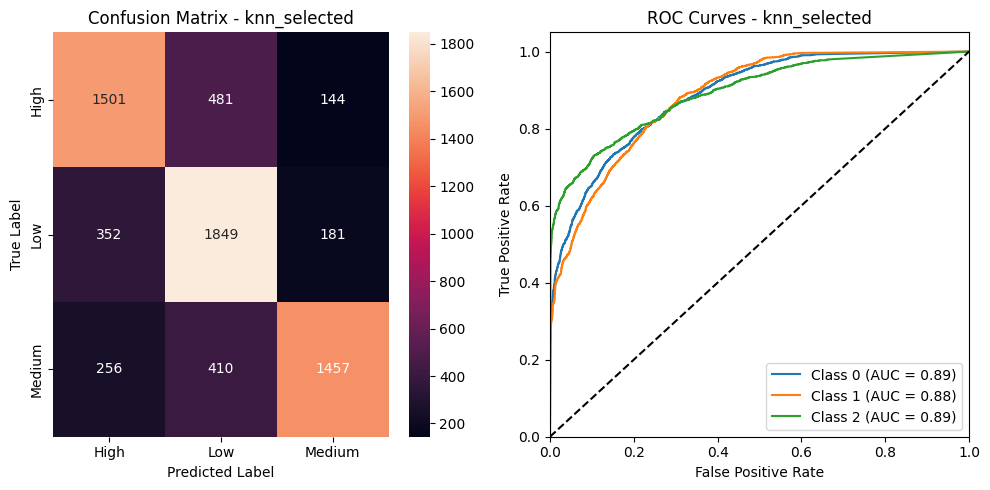

In [ ]:
model_name = 'knn_selected'

# Train with full features
print(f"\nTraining {model_name} with full features...")
model = train_model(X_train_selected, y_train, model_name)

# Plot learning curves
plot_learning_curves(X_train_selected, y_train, model_name)

# Analyze feature importance for applicable models
if model_name in ['decision_tree', 'xgboost']:
    analyze_feature_importance(model_name)

# Analyze model performance
results[model_name] = analyze_model(model_name, X_test_selected, y_test)


Training svm_linear_selected with full features...

Training svm_linear_selected...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best parameters: {'C': 1.0, 'class_weight': 'balanced'}


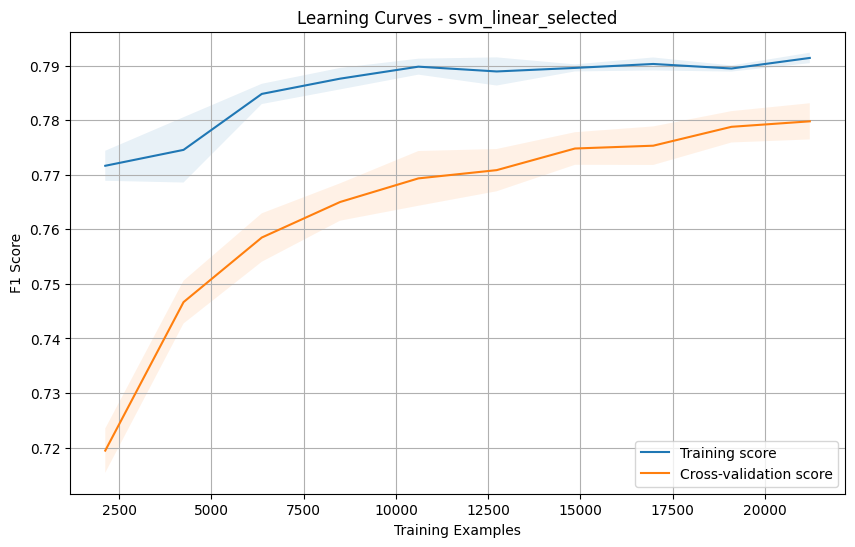


Classification Report:
              precision    recall  f1-score   support

        High       0.72      0.83      0.77      2126
         Low       0.77      0.82      0.79      2382
      Medium       0.91      0.70      0.79      2123

    accuracy                           0.78      6631
   macro avg       0.80      0.78      0.78      6631
weighted avg       0.80      0.78      0.78      6631



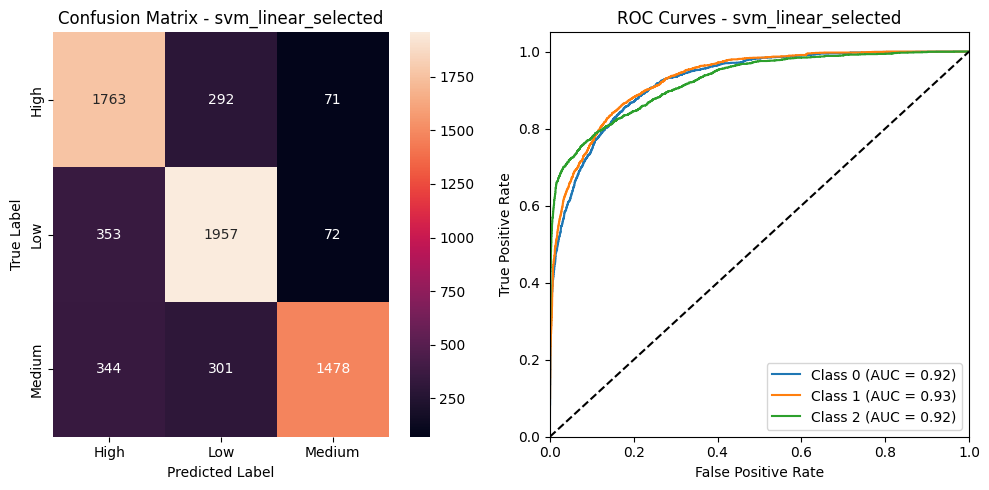

In [ ]:
model_name = 'svm_linear_selected'

# Train with full features
print(f"\nTraining {model_name} with full features...")
model = train_model(X_train_selected, y_train, model_name)

# Plot learning curves
plot_learning_curves(X_train_selected, y_train, model_name)

# Analyze feature importance for applicable models
if model_name in ['decision_tree', 'xgboost']:
    analyze_feature_importance(model_name)

# Analyze model performance
results[model_name] = analyze_model(model_name, X_test_selected, y_test)


Training svm_rbf_selected with full features...

Training svm_rbf_selected...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 10.0, 'class_weight': 'balanced', 'gamma': 'scale'}


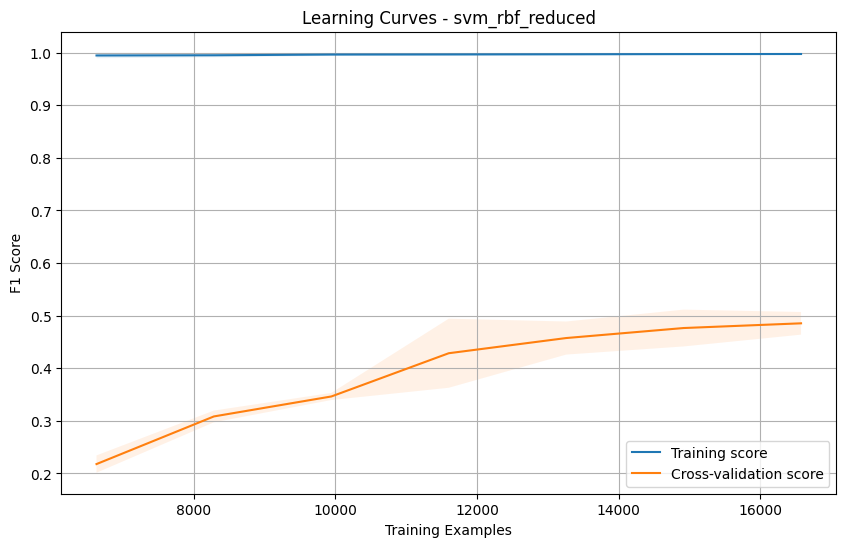


Classification Report:
              precision    recall  f1-score   support

        High       0.75      0.83      0.78      2126
         Low       0.80      0.83      0.82      2382
      Medium       0.87      0.74      0.80      2123

    accuracy                           0.80      6631
   macro avg       0.81      0.80      0.80      6631
weighted avg       0.81      0.80      0.80      6631



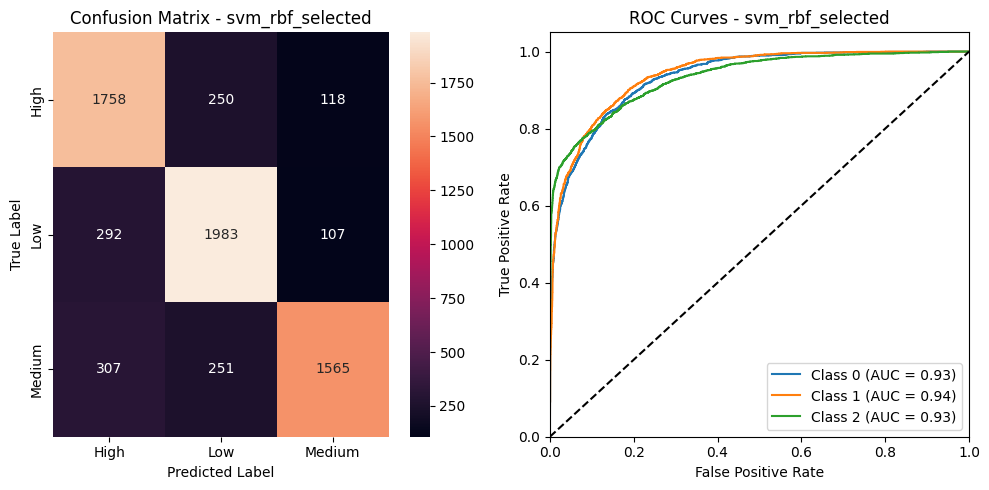

In [ ]:
model_name = 'svm_rbf_selected'

# Train with full features
print(f"\nTraining {model_name} with full features...")
model = train_model(X_train_selected, y_train, model_name)

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=2, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_weighted'
    )

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title(f'Learning Curves - svm_rbf_reduced')
plt.legend(loc='best')
plt.grid()
plt.show()

# Analyze feature importance for applicable models
if model_name in ['decision_tree', 'xgboost']:
    analyze_feature_importance(model_name)

# Analyze model performance
results[model_name] = analyze_model(model_name, X_test_selected, y_test)


Training xgboost_selected with full features...

Training xgboost_selected...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}


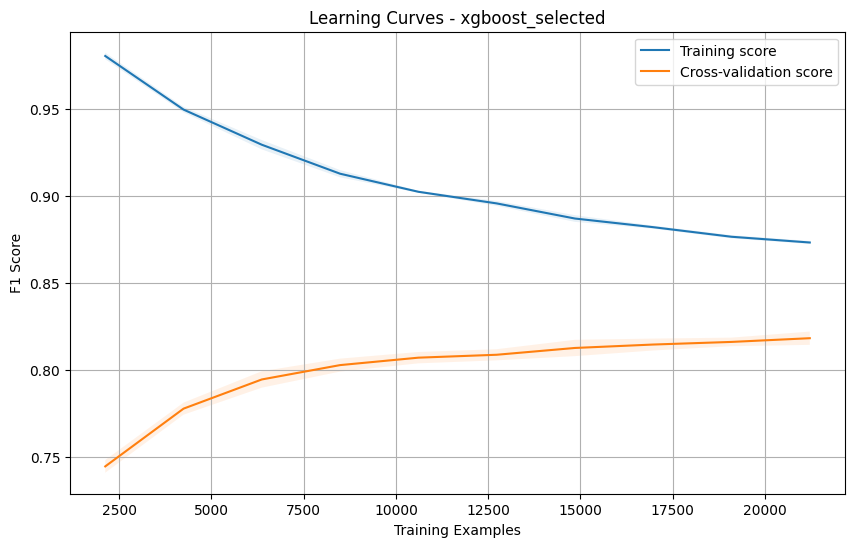


Classification Report:
              precision    recall  f1-score   support

        High       0.77      0.82      0.80      2126
         Low       0.78      0.87      0.83      2382
      Medium       0.90      0.74      0.81      2123

    accuracy                           0.81      6631
   macro avg       0.82      0.81      0.81      6631
weighted avg       0.82      0.81      0.81      6631



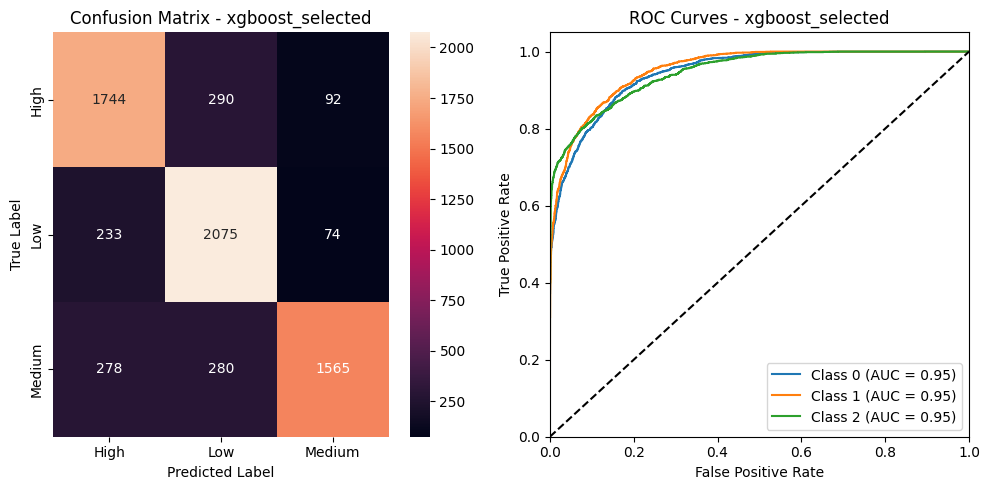

In [ ]:
model_name = 'xgboost_selected'

# Train with full features
print(f"\nTraining {model_name} with full features...")
model = train_model(X_train_selected, y_train, model_name)

# Plot learning curves
plot_learning_curves(X_train_selected, y_train, model_name)

# Analyze feature importance for applicable models
if model_name in ['decision_tree', 'xgboost_selected']:
    analyze_feature_importance(model_name)

# Analyze model performance
results[model_name] = analyze_model(model_name, X_test_selected, y_test)

In [ ]:
metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
c = pd.DataFrame(columns=metrics)

for model_name, result in results.items():
    c.loc[model_name] = [
        result['accuracy'],
        result['precision'],
        result['recall'],
        result['f1']
    ]

print(c)

                        accuracy  precision_weighted  recall_weighted  \
decision_tree           0.712411            0.717845         0.712411   
naive_bayes             0.786910            0.810699         0.786910   
knn                     0.631428            0.709213         0.631428   
svm_linear              0.821746            0.824645         0.821746   
decision_tree_reduced   0.629618            0.647517         0.629618   
knn_reduced             0.626753            0.723778         0.626753   
naive_bayes_reduced     0.368723            0.771056         0.368723   
svm_linear_reduced      0.816468            0.818791         0.816468   
svm_rbf                 0.826874            0.828006         0.826874   
svm_rbf_reduced         0.822199            0.824003         0.822199   
xgboost                 0.829136            0.835777         0.829136   
xgboost_reduced         0.782084            0.788002         0.782084   
decision_tree_selected  0.719801            0.72311